# Pixar History Analysis

## Import Necessary Libraries

In [1]:
#Manipulation libraries
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt 
import seaborn as sns

#Hypothesis testing libraries
from scipy import stats

#Statistical modelling libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

#Model tracking
import mlflow

In [2]:
# Allow display all rows
pd.set_option('display.max_rows', None)

## Initial Examination of Datasets

### Pixar Films Data
Containing main information of films, including title, release date, run time, film rating, and plot

In [3]:
pixar_films = pd.read_csv("pixar_films.csv")

In [4]:
pixar_films['release_date'] = pd.to_datetime(pixar_films['release_date'])

In [5]:
pixar_films.head()

,number,film,release_date,run_time,film_rating,plot
0,1,Toy Story,1995-11-22,81,G,A cowboy doll is profoundly threatened and jea...
1,2,A Bug's Life,1998-11-25,95,G,"A misfit ant, looking for ""warriors"" to save h..."
2,3,Toy Story 2,1999-11-24,92,G,"When Woody is stolen by a toy collector, Buzz ..."
3,4,"Monsters, Inc.",2001-11-02,92,G,"In order to power the city, monsters have to s..."
4,5,Finding Nemo,2003-05-30,100,G,After his son is captured in the Great Barrier...


In [6]:
pixar_films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   number        28 non-null     int64         
 1   film          28 non-null     object        
 2   release_date  28 non-null     datetime64[ns]
 3   run_time      28 non-null     int64         
 4   film_rating   28 non-null     object        
 5   plot          28 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.4+ KB


In [7]:
pixar_films.describe()

,number,release_date,run_time
count,28.000000,28,28.000000
mean,14.500000,2012-11-18 21:25:42.857142784,100.392857
min,1.000000,1995-11-22 00:00:00,81.000000
25%,7.750000,2007-03-24 18:00:00,95.000000
50%,14.500000,2014-06-20 00:00:00,100.000000
75%,21.250000,2019-08-24 18:00:00,104.250000
max,28.000000,2024-06-14 00:00:00,118.000000
std,8.225975,NaN,8.047725


In [8]:
pixar_films.isna().sum()

number          0
film            0
release_date    0
run_time        0
film_rating     0
plot            0
dtype: int64

With regards to release date, the next step is to extract relevant information that can be useful, such as release month, quarter, year, and decade

In [9]:
pixar_films['release_month'] = pixar_films['release_date'].dt.month
pixar_films['release_quarter'] = pixar_films['release_date'].dt.quarter
pixar_films['release_year'] = pixar_films['release_date'].dt.year
pixar_films['release_decade'] = (pixar_films['release_year'] // 10) * 10

In [10]:
pixar_films.head()

,number,film,release_date,run_time,film_rating,plot,release_month,release_quarter,release_year,release_decade
0,1,Toy Story,1995-11-22,81,G,A cowboy doll is profoundly threatened and jea...,11,4,1995,1990
1,2,A Bug's Life,1998-11-25,95,G,"A misfit ant, looking for ""warriors"" to save h...",11,4,1998,1990
2,3,Toy Story 2,1999-11-24,92,G,"When Woody is stolen by a toy collector, Buzz ...",11,4,1999,1990
3,4,"Monsters, Inc.",2001-11-02,92,G,"In order to power the city, monsters have to s...",11,4,2001,2000
4,5,Finding Nemo,2003-05-30,100,G,After his son is captured in the Great Barrier...,5,2,2003,2000


### Pixar People Data
Containing information of people's roles in producing films

In [11]:
pixar_people = pd.read_csv("pixar_people.csv")

In [12]:
pixar_people.head()

,film,role_type,name
0,Toy Story,Director,John Lasseter
1,Toy Story,Musician,Randy Newman
2,Toy Story,Producer,Bonnie Arnold
3,Toy Story,Producer,Ralph Guggenheim
4,Toy Story,Screenwriter,Joel Cohen


In [13]:
pixar_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   film       260 non-null    object
 1   role_type  260 non-null    object
 2   name       260 non-null    object
dtypes: object(3)
memory usage: 6.2+ KB


In [14]:
pixar_people.describe()

,film,role_type,name
count,260,260,260
unique,28,6,95
top,Toy Story 2,Storywriter,Andrew Stanton
freq,14,84,20


In [15]:
pixar_people.isna().sum()

film         0
role_type    0
name         0
dtype: int64

### Genres Data

Containing information of films' genres and subgenres

In [16]:
genres = pd.read_csv("genres.csv")

In [17]:
genres.head()

,film,category,value
0,Toy Story,Genre,Adventure
1,Toy Story,Genre,Animation
2,Toy Story,Genre,Comedy
3,Toy Story,Subgenre,Buddy Comedy
4,Toy Story,Subgenre,Computer Animation


In [18]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   film      204 non-null    object
 1   category  204 non-null    object
 2   value     204 non-null    object
dtypes: object(3)
memory usage: 4.9+ KB


In [19]:
genres.describe()

,film,category,value
count,204,204,204
unique,28,2,39
top,Cars 2,Subgenre,Adventure
freq,9,120,28


In [20]:
genres.isna().sum()

film        0
category    0
value       0
dtype: int64

### Box Office Data
Containing information of films' production budgets and box office earnings

In [21]:
box_office = pd.read_csv("box_office.csv")

In [22]:
box_office.head()

,film,budget,box_office_us_canada,box_office_other,box_office_worldwide
0,Toy Story,30000000.0,223225679,171210907,394436586
1,A Bug's Life,120000000.0,162798565,200460294,363258859
2,Toy Story 2,90000000.0,245852179,265506097,511358276
3,"Monsters, Inc.",115000000.0,255873250,272900000,528773250
4,Finding Nemo,94000000.0,339714978,531300000,871014978


In [23]:
box_office.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   film                  28 non-null     object 
 1   budget                27 non-null     float64
 2   box_office_us_canada  28 non-null     int64  
 3   box_office_other      28 non-null     int64  
 4   box_office_worldwide  28 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.2+ KB


In [24]:
box_office.describe()

,budget,box_office_us_canada,box_office_other,box_office_worldwide
count,2.700000e+01,2.800000e+01,2.800000e+01,2.800000e+01
mean,1.611481e+08,2.475444e+08,3.611199e+08,6.086643e+08
std,4.522142e+07,1.631609e+08,2.300110e+08,3.826497e+08
min,3.000000e+07,9.461540e+05,2.041436e+07,2.181336e+07
25%,1.350000e+08,1.540453e+08,2.069555e+08,3.787627e+08
50%,1.750000e+08,2.305457e+08,3.218588e+08,5.338782e+08
75%,2.000000e+08,3.046819e+08,5.086871e+08,8.253837e+08
max,2.000000e+08,6.529802e+08,1.045051e+09,1.698031e+09


In [25]:
box_office.isna().sum()

film                    0
budget                  1
box_office_us_canada    0
box_office_other        0
box_office_worldwide    0
dtype: int64

Since one entry has no budget value, this value will be imputed with the median budget.

In [26]:
box_office['budget'].fillna(value=box_office['budget'].median(), inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39644\1023510796.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  box_office['budget'].fillna(value=box_office['budget'].median(), inplace=True)


In [27]:
box_office.isna().sum()

film                    0
budget                  0
box_office_us_canada    0
box_office_other        0
box_office_worldwide    0
dtype: int64

### Public Response Data

Containing information of film's review scores on Rotten Tomatoes, Metacritic, CinemaScore, and IMDB

In [28]:
public_response = pd.read_csv("public_response.csv")

In [29]:
public_response.head()

,film,rotten_tomatoes_score,rotten_tomatoes_counts,metacritic_score,metacritic_counts,cinema_score,imdb_score,imdb_counts
0,Toy Story,100.0,96,95.0,26,A,8.3,1089101
1,A Bug's Life,92.0,91,78.0,23,A,7.2,319596
2,Toy Story 2,100.0,172,88.0,34,A+,7.9,630573
3,"Monsters, Inc.",96.0,199,79.0,35,A+,8.1,1000657
4,Finding Nemo,99.0,270,90.0,38,A+,8.2,1132877


In [30]:
public_response.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   film                    28 non-null     object 
 1   rotten_tomatoes_score   28 non-null     float64
 2   rotten_tomatoes_counts  28 non-null     int64  
 3   metacritic_score        28 non-null     float64
 4   metacritic_counts       28 non-null     int64  
 5   cinema_score            25 non-null     object 
 6   imdb_score              28 non-null     float64
 7   imdb_counts             28 non-null     int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 1.9+ KB


In [31]:
public_response.describe()

,rotten_tomatoes_score,rotten_tomatoes_counts,metacritic_score,metacritic_counts,imdb_score,imdb_counts
count,28.000000,28.000000,28.000000,28.000000,28.000000,2.800000e+01
mean,88.357143,273.821429,78.142857,43.464286,7.542857,5.256077e+05
std,13.447330,84.248773,12.408821,9.558716,0.658522,3.688713e+05
min,40.000000,91.000000,57.000000,23.000000,6.100000,1.270450e+05
25%,79.750000,220.000000,68.250000,37.000000,7.175000,1.955322e+05
50%,94.500000,266.000000,79.500000,41.000000,7.550000,3.958430e+05
75%,97.000000,324.000000,88.500000,52.000000,8.100000,8.385082e+05
max,100.000000,459.000000,96.000000,59.000000,8.400000,1.226415e+06


In [32]:
public_response.isna().sum()

film                      0
rotten_tomatoes_score     0
rotten_tomatoes_counts    0
metacritic_score          0
metacritic_counts         0
cinema_score              3
imdb_score                0
imdb_counts               0
dtype: int64

In [33]:
public_response['cinema_score'].value_counts()

cinema_score
A     15
A+     7
A-     3
Name: count, dtype: int64

In [34]:
#Since the majority of movies are A rated, all remaining films will be imputed with a CinemaScore of A
public_response['cinema_score'].fillna(value='A', inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39644\2674400917.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  public_response['cinema_score'].fillna(value='A', inplace=True)


In [35]:
public_response.isna().sum()

film                      0
rotten_tomatoes_score     0
rotten_tomatoes_counts    0
metacritic_score          0
metacritic_counts         0
cinema_score              0
imdb_score                0
imdb_counts               0
dtype: int64

In [36]:
#Map CinemaScore rating to numeral raing (A+ for 4.0, A for 3.7, A- for 3.3)
public_response['cinema_score'] = public_response['cinema_score'].replace({'A+': 4.0, 'A': 3.7, 'A-': 3.3})

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39644\1429005626.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  public_response['cinema_score'] = public_response['cinema_score'].replace({'A+': 4.0, 'A': 3.7, 'A-': 3.3})


In [37]:
public_response.head()

,film,rotten_tomatoes_score,rotten_tomatoes_counts,metacritic_score,metacritic_counts,cinema_score,imdb_score,imdb_counts
0,Toy Story,100.0,96,95.0,26,3.7,8.3,1089101
1,A Bug's Life,92.0,91,78.0,23,3.7,7.2,319596
2,Toy Story 2,100.0,172,88.0,34,4.0,7.9,630573
3,"Monsters, Inc.",96.0,199,79.0,35,4.0,8.1,1000657
4,Finding Nemo,99.0,270,90.0,38,4.0,8.2,1132877


### Academy Data

Containing information about different Academy awards that Pixar films are nominated or won

In [38]:
academy = pd.read_csv("academy.csv")

In [39]:
academy.head()

,film,award_type,status
0,Toy Story,Animated Feature,Award not yet introduced
1,Toy Story,Original Screenplay,Nominated
2,Toy Story,Adapted Screenplay,Ineligible
3,Toy Story,Original Score,Nominated
4,Toy Story,Original Song,Nominated


In [40]:
academy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   film        89 non-null     object
 1   award_type  89 non-null     object
 2   status      89 non-null     object
dtypes: object(3)
memory usage: 2.2+ KB


In [41]:
academy.describe()

,film,award_type,status
count,89,89,89
unique,28,9,5
top,WALL-E,Animated Feature,Nominated
freq,7,22,40


In [42]:
academy.isna().sum()

film          0
award_type    0
status        0
dtype: int64

## Examine Financial Performance of Pixar Films: Which Films Were The Most Successful In Terms Of Return On Investment?

ROI can be calculated using the formula:
ROI = (Revenue - Budget) / Budget

In [43]:
#Calculate ROI
box_office['roi'] = ((box_office['box_office_worldwide'] - box_office['budget']) / box_office['budget']) * 100

In [44]:
#Sort by ROI
box_office_roi_sorted = box_office.sort_values(by='roi', ascending=False)

In [45]:
#Extract 5 films with top ROI
box_office_roi_sorted.head(5)

,film,budget,box_office_us_canada,box_office_other,box_office_worldwide,roi
0,Toy Story,30000000.0,223225679,171210907,394436586,1214.788620
4,Finding Nemo,94000000.0,339714978,531300000,871014978,826.611679
27,Inside Out 2,200000000.0,652980194,1045050771,1698030965,749.015483
5,The Incredibles,92000000.0,261441092,370001000,631442092,586.350100
19,Incredibles 2,200000000.0,608581744,634223615,1242805359,521.402679


From the table, we can clearly see that the top 5 films in terms of Return on Investment are Toy Story, Finding Nemo, Inside OUt 2, The Incredibles, and Incredibles 2.

## What Is The Ideal Budget For Producing Pixar Films?

In this section, we will examine what budget yields the highest box office revenue and ROI for Pixar films

In [46]:
pixar_films_box_office = pd.merge(pixar_films, box_office, on='film')

In [47]:
pixar_films_box_office

,number,film,release_date,run_time,film_rating,plot,release_month,release_quarter,release_year,release_decade,budget,box_office_us_canada,box_office_other,box_office_worldwide,roi
0,1,Toy Story,1995-11-22,81,G,A cowboy doll is profoundly threatened and jea...,11,4,1995,1990,30000000.0,223225679,171210907,394436586,1214.788620
1,2,A Bug's Life,1998-11-25,95,G,"A misfit ant, looking for ""warriors"" to save h...",11,4,1998,1990,120000000.0,162798565,200460294,363258859,202.715716
2,3,Toy Story 2,1999-11-24,92,G,"When Woody is stolen by a toy collector, Buzz ...",11,4,1999,1990,90000000.0,245852179,265506097,511358276,468.175862
3,4,"Monsters, Inc.",2001-11-02,92,G,"In order to power the city, monsters have to s...",11,4,2001,2000,115000000.0,255873250,272900000,528773250,359.802826
4,5,Finding Nemo,2003-05-30,100,G,After his son is captured in the Great Barrier...,5,2,2003,2000,94000000.0,339714978,531300000,871014978,826.611679
5,6,The Incredibles,2004-11-05,115,PG,"While trying to lead a quiet suburban life, a ...",11,4,2004,2000,92000000.0,261441092,370001000,631442092,586.350100
6,7,Cars,2006-06-09,116,G,"On the way to the biggest race of his life, a ...",6,2,2006,2000,120000000.0,244082982,217900167,461983149,284.985957
7,8,Ratatouille,2007-06-29,111,G,A rat who can cook makes an unusual alliance w...,6,2,2007,2000,150000000.0,206445654,417280431,623726085,315.817390
8,9,WALL-E,2008-06-27,98,G,A robot who is responsible for cleaning a wast...,6,2,2008,2000,180000000.0,223808164,297503696,521311860,189.617700
9,10,Up,2009-05-29,96,PG,78-year-old Carl Fredricksen travels to South ...,5,2,2009,2000,175000000.0,293004164,442094918,735099082,320.056618


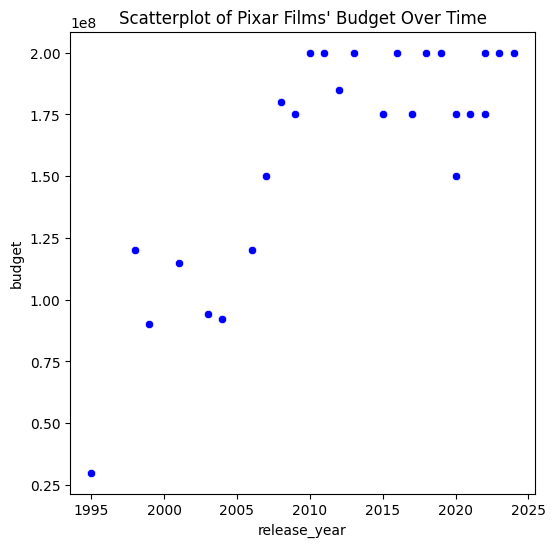

In [48]:
#Plot budget over time
plt.figure(figsize=(6,6))
plt.title("Scatterplot of Pixar Films' Budget Over Time")
sns.scatterplot(data=pixar_films_box_office, x='release_year', y='budget', color='blue')
plt.show()

From the above plot, it can be seen that the first Pixar movies have significantly lower budgets than later ones. Eventually, from 2007 onwards (starting with Ratatouille), the budgets stayed more stable from $150m to $200m. Therefore, in suggesting the ideal budget for producing a new Pixar films, only the films from 2007 will be observed so that everything becomes more realistic with current prices and technologies.

We will divide the budget into two ranges, $150 <= b <= $175m and $175m < b <= $200m, where b represents the budget for producing each film, with each range accounting for approximately half of the films produced since 2007.

In [49]:
pixar_films_box_office_modern = pixar_films_box_office[pixar_films_box_office['release_year'] >= 2007]

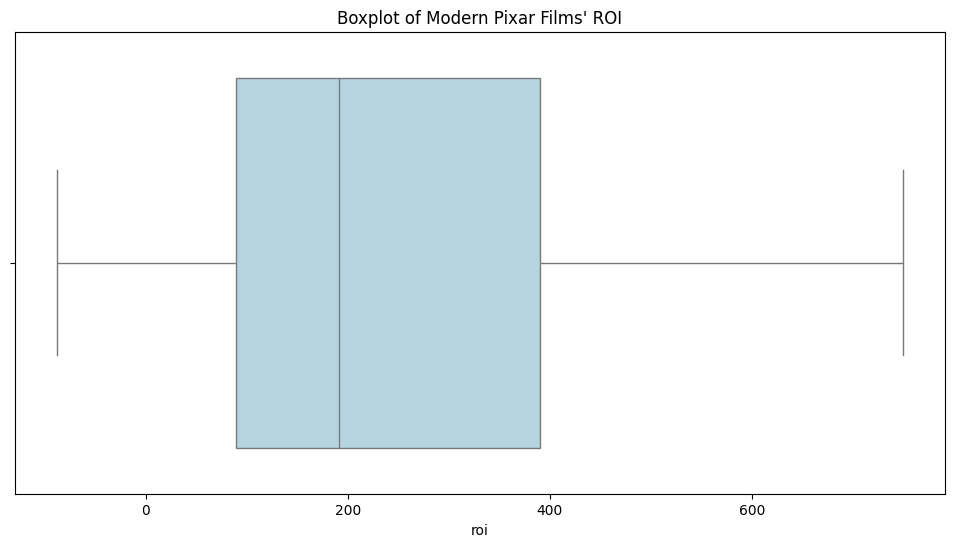

In [50]:
#Box plot of modern Pixar films' ROI
plt.figure(figsize=(12,6))
plt.title("Boxplot of Modern Pixar Films' ROI")
sns.boxplot(data=pixar_films_box_office_modern, x='roi', color='lightblue')
plt.show()

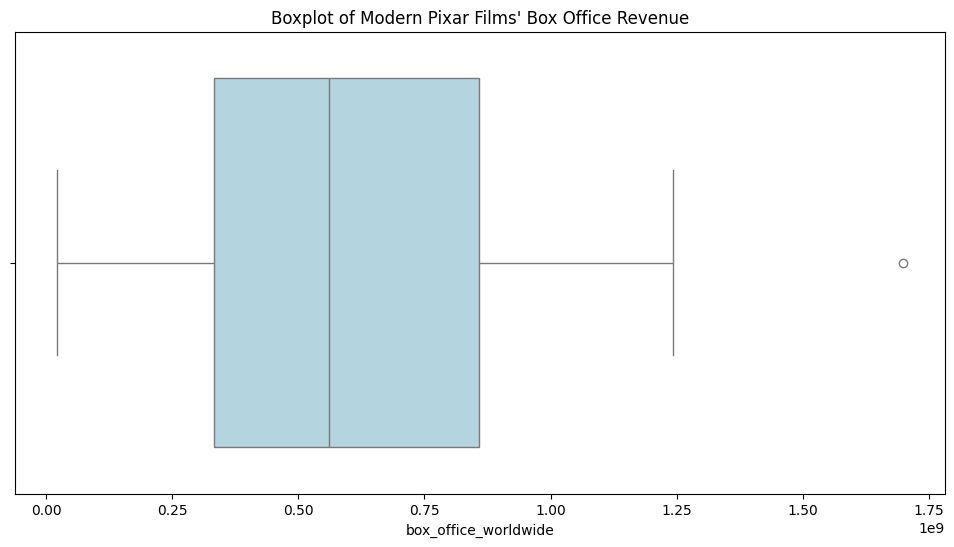

In [51]:
#Box plot of modern Pixar films' box office revenue
plt.figure(figsize=(12,6))
plt.title("Boxplot of Modern Pixar Films' Box Office Revenue")
sns.boxplot(data=pixar_films_box_office_modern, x='box_office_worldwide', color='lightblue')
plt.show()

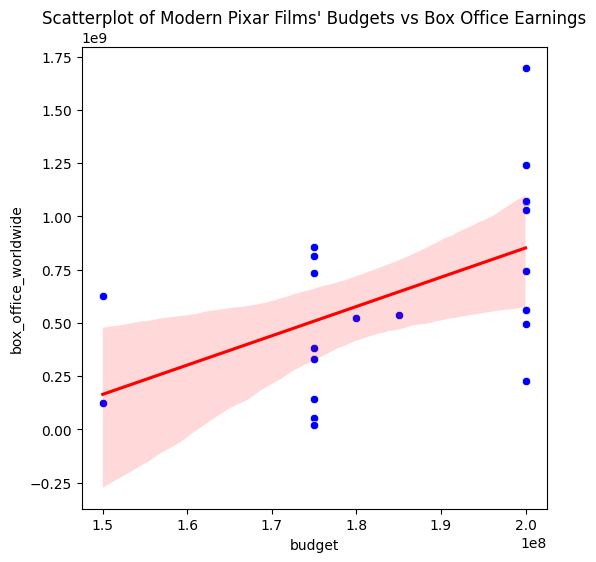

In [52]:
#Plot relationship between budget and box office revenue
plt.figure(figsize=(6,6))
plt.title("Scatterplot of Modern Pixar Films' Budgets vs Box Office Earnings")
sns.scatterplot(data=pixar_films_box_office_modern, x='budget', y='box_office_worldwide', color='blue')
sns.regplot(data=pixar_films_box_office_modern, x='budget', y='box_office_worldwide', scatter=False, color='red')
plt.show()

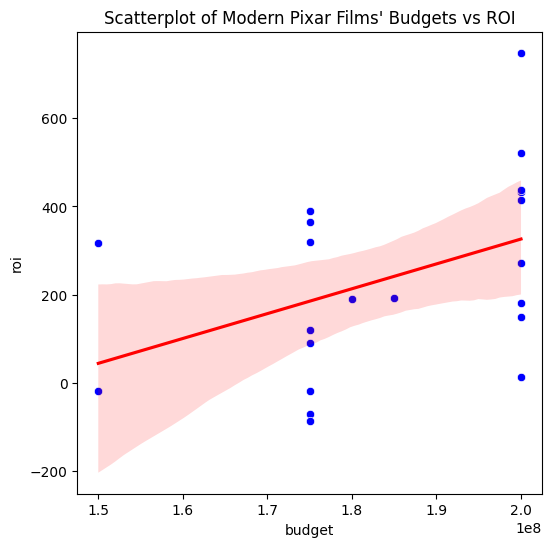

In [53]:
#Plot relationship between budget and ROI
plt.figure(figsize=(6,6))
plt.title("Scatterplot of Modern Pixar Films' Budgets vs ROI")
sns.scatterplot(data=pixar_films_box_office_modern, x='budget', y='roi', color='blue')
sns.regplot(data=pixar_films_box_office_modern, x='budget', y='roi', scatter=False, color='red')
plt.show()

In [54]:
pixar_films_box_office_modern[['budget', 'box_office_worldwide']].corr()

,budget,box_office_worldwide
budget,1.000000,0.517382
box_office_worldwide,0.517382,1.000000


In [55]:
pixar_films_box_office_modern[['budget', 'roi']].corr()

,budget,roi
budget,1.000000,0.423367
roi,0.423367,1.000000


Overall, it seems that there is a moderate positive correlation between budget and box office revenue and ROI. However, such correlation is only at a moderate level.

Therefore, we will then examine further into the differences by performing two hypothesis tests:

Test 1:

* H0: There is no difference between box office revenue of low and high budget Pixar films
* H1: High budget Pixar films generate higher box office revenue on average

Test 2:

* H0: There is no difference between ROI of low and high budget Pixar films
* H1: High budget Pixar films generate higher ROI on average

Due to the small sample size, and unknown distribution of the variables, the Mann-Whitney U test will be used.

In [56]:
#Categorize into low and high budget films
pixar_films_box_office_modern['budget_group'] = pixar_films_box_office_modern['budget'].apply(lambda x: 'Low' if x <= 175000000 else 'High')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39644\1460360873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pixar_films_box_office_modern['budget_group'] = pixar_films_box_office_modern['budget'].apply(lambda x: 'Low' if x <= 175000000 else 'High')


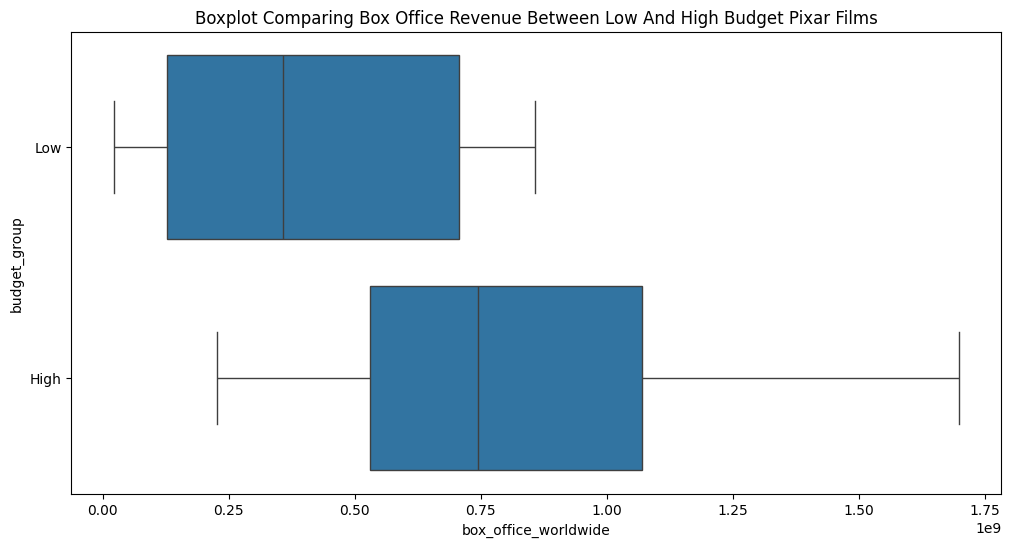

In [57]:
#Comparing box office revenue between low and high budget Pixar films
plt.figure(figsize=(12, 6))
sns.boxplot(data=pixar_films_box_office_modern, x='box_office_worldwide', y='budget_group')
plt.title('Boxplot Comparing Box Office Revenue Between Low And High Budget Pixar Films')
plt.show()

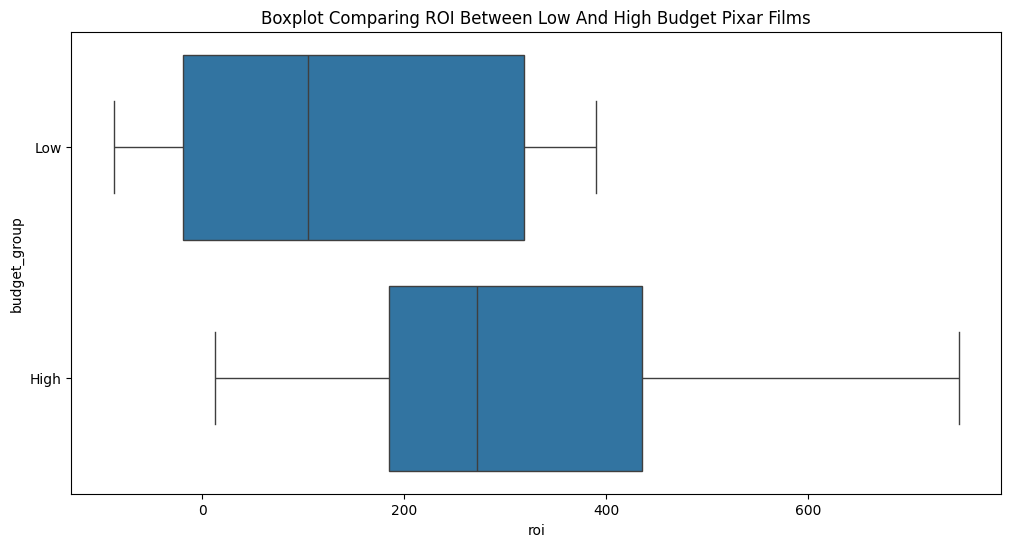

In [58]:
#Comparing ROI between low and high budget Pixar films
plt.figure(figsize=(12, 6))
sns.boxplot(data=pixar_films_box_office_modern, x='roi', y='budget_group')
plt.title('Boxplot Comparing ROI Between Low And High Budget Pixar Films')
plt.show()

From the two box plots, we can both see that the higher budget group gained better box office revenue and ROI and the lower budget group

#### Extract mean values of box office revenue and ROI of two budget groups

In [59]:
print(f"The mean box office revenue of the low budget group is {pixar_films_box_office_modern[pixar_films_box_office_modern['budget_group'] == 'Low']['box_office_worldwide'].mean()}")

The mean box office revenue of the low budget group is 408398543.9


In [60]:
print(f"The mean ROI of the low budget group is {pixar_films_box_office_modern[pixar_films_box_office_modern['budget_group'] == 'Low']['roi'].mean()}")

The mean ROI of the low budget group is 140.47183432380953


In [61]:
print(f"The mean box office revenue of the high budget group is {pixar_films_box_office_modern[pixar_films_box_office_modern['budget_group'] == 'High']['box_office_worldwide'].mean()}")

The mean box office revenue of the high budget group is 836031664.2727273


In [62]:
print(f"The mean ROI of the high budget group is {pixar_films_box_office_modern[pixar_films_box_office_modern['budget_group'] == 'High']['roi'].mean()}")

The mean ROI of the high budget group is 322.6351449140049


#### Perform hypothesis testing on box office revenue

In [63]:
#Perform Mann-Whitney U-test for box office revenue
u_stat_bo, p_val_bo_u = stats.mannwhitneyu(
    pixar_films_box_office_modern.loc[pixar_films_box_office_modern['budget_group']=='High', 'box_office_worldwide'],
    pixar_films_box_office_modern.loc[pixar_films_box_office_modern['budget_group']=='Low', 'box_office_worldwide'],
    alternative='greater'
)

In [64]:
print(f"The U-statistic for box office revenue is {u_stat_bo}")

The U-statistic for box office revenue is 86.0


In [65]:
print(f"The p-value for box office revenue is {p_val_bo_u}")

The p-value for box office revenue is 0.015866996878448274


#### Perform hypothesis testing on ROI

In [66]:
#Perform Mann-Whitney U-test for ROI
u_stat_roi, p_val_roi_u = stats.mannwhitneyu(
    pixar_films_box_office_modern.loc[pixar_films_box_office_modern['budget_group']=='High', 'roi'],
    pixar_films_box_office_modern.loc[pixar_films_box_office_modern['budget_group']=='Low', 'roi'],
    alternative='greater'
)

In [67]:
print(f"The U-statistic for ROI is {u_stat_roi}")

The U-statistic for ROI is 84.0


In [68]:
print(f"The p-value for ROI is {p_val_roi_u}")

The p-value for ROI is 0.022379647287786138


For both hypothesis tests, the p-value is less than 0.05. 

Therefore, at $\alpha$ = 0.05, we reject the null hypotheses.

At 95% confidence, we can conclude that despite higher budget required for production, such films eventually gained higher box office revenue and return on investment. Therefore, a higher budget (higher than $175m but no more than $200m) is ideal for Pixar in producing films.

## Examine Awards Achieved By Pixar Films

In [69]:
academy_status_values = academy['status'].drop_duplicates()
academy_status_values

0     Award not yet introduced
1                    Nominated
2                   Ineligible
5      Won Special Achievement
15                         Won
Name: status, dtype: object

In [70]:
academy_won = academy[(academy['status'] == "Won Special Achievement") | (academy['status'] == "Won")]

In [71]:
academy_won

,film,award_type,status
5,Toy Story,Other,Won Special Achievement
15,"Monsters, Inc.",Original Song,Won
17,Finding Nemo,Animated Feature,Won
22,The Incredibles,Animated Feature,Won
25,The Incredibles,Sound Editing,Won
30,Ratatouille,Animated Feature,Won
36,WALL-E,Animated Feature,Won
44,Up,Animated Feature,Won
47,Up,Original Score,Won
50,Toy Story 3,Animated Feature,Won


In [72]:
all_films = academy['film'].unique()
awards_won_counts = academy_won['film'].value_counts()
awards_won_counts_df = pd.Series(awards_won_counts).reindex(all_films, fill_value=0)

In [73]:
awards_won_counts_df = awards_won_counts_df.reset_index()
awards_won_counts_df.columns = ['film', 'num_awards_won']

In [74]:
#Sort films by number of Academy Awards won
awards_won_counts_df_sorted = awards_won_counts_df.sort_values(by='num_awards_won', ascending=False)

In [75]:
awards_won_counts_df_sorted.head(10)

,film,num_awards_won
9,Up,2
22,Soul,2
18,Coco,2
5,The Incredibles,2
10,Toy Story 3,2
0,Toy Story,1
20,Toy Story 4,1
12,Brave,1
14,Inside Out,1
8,WALL-E,1


The 5 films with most Academy Awards won, which are also the only ones to have won multiple Academy Awards, are Up, Soul, Coco, The Incredibles, and Toy Story 3

## Comparing Financial Success vs Academy Awards Won

In [76]:
#Join Academy Awards count data and box office data
academy_box_office = pd.merge(awards_won_counts_df, box_office, on='film')

In [77]:
# Add variable for whether films have won an Academy Award
academy_box_office["won_awards"] = academy_box_office["num_awards_won"] > 0

In [78]:
academy_box_office.head()

,film,num_awards_won,budget,box_office_us_canada,box_office_other,box_office_worldwide,roi,won_awards
0,Toy Story,1,30000000.0,223225679,171210907,394436586,1214.788620,True
1,A Bug's Life,0,120000000.0,162798565,200460294,363258859,202.715716,False
2,Toy Story 2,0,90000000.0,245852179,265506097,511358276,468.175862,False
3,"Monsters, Inc.",1,115000000.0,255873250,272900000,528773250,359.802826,True
4,Finding Nemo,1,94000000.0,339714978,531300000,871014978,826.611679,True


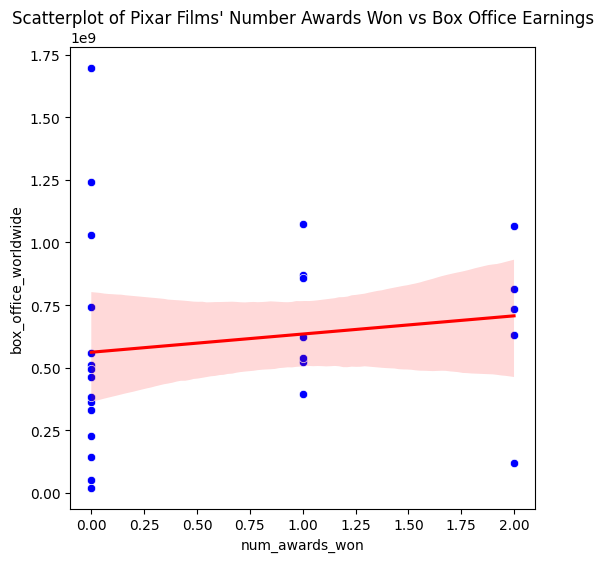

In [79]:
plt.figure(figsize=(6,6))
plt.title("Scatterplot of Pixar Films' Number Awards Won vs Box Office Earnings")
sns.scatterplot(data=academy_box_office, x='num_awards_won', y='box_office_worldwide', color='blue')
sns.regplot(data=academy_box_office, x='num_awards_won', y='box_office_worldwide', scatter=False, color='red')
plt.show()

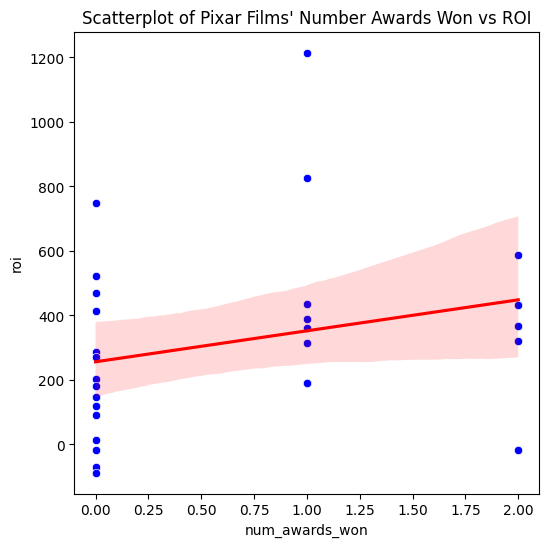

In [80]:
plt.figure(figsize=(6,6))
plt.title("Scatterplot of Pixar Films' Number Awards Won vs ROI")
sns.scatterplot(data=academy_box_office, x='num_awards_won', y='roi', color='blue')
sns.regplot(data=academy_box_office, x='num_awards_won', y='roi', scatter=False, color='red')
plt.show()

In [81]:
#Correlation between number of Academy Awards won and box office revenue
academy_box_office[['num_awards_won', 'box_office_worldwide']].corr()

,num_awards_won,box_office_worldwide
num_awards_won,1.000000,0.148083
box_office_worldwide,0.148083,1.000000


In [82]:
#Correlation between number of Academy Awards won and box office revenue
academy_box_office[['num_awards_won', 'roi']].corr()

,num_awards_won,roi
num_awards_won,1.000000,0.259377
roi,0.259377,1.000000


It can be seen that while positive correlation exists between number of Academy Awards won and box office revenue and ROI, this correlation is rather weak. Eventually it can be seen that films with the highest box office earnings did not win any Academy Awards, while the film with the highest ROI only won 1 Academy Award.

Therefore, we will also look at whether films have won any Academy Awards as another metric to compare box office revenue and ROI.

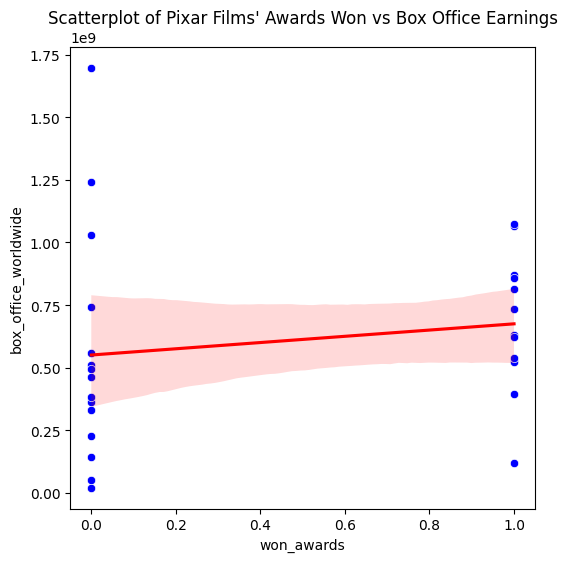

In [83]:
plt.figure(figsize=(6,6))
plt.title("Scatterplot of Pixar Films' Awards Won vs Box Office Earnings")
sns.scatterplot(data=academy_box_office, x='won_awards', y='box_office_worldwide', color='blue')
sns.regplot(data=academy_box_office, x='won_awards', y='box_office_worldwide', scatter=False, color='red')
plt.show()

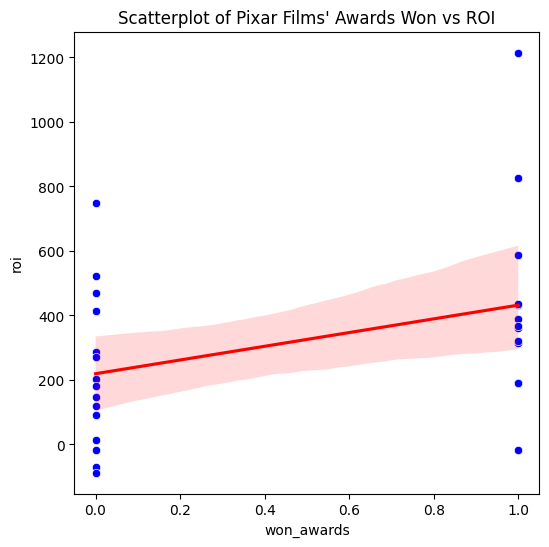

In [84]:
plt.figure(figsize=(6,6))
plt.title("Scatterplot of Pixar Films' Awards Won vs ROI")
sns.scatterplot(data=academy_box_office, x='won_awards', y='roi', color='blue')
sns.regplot(data=academy_box_office, x='won_awards', y='roi', scatter=False, color='red')
plt.show()

In [85]:
academy_box_office[['won_awards', 'box_office_worldwide']].corr()

,won_awards,box_office_worldwide
won_awards,1.000000,0.165171
box_office_worldwide,0.165171,1.000000


In [86]:
academy_box_office[['won_awards', 'roi']].corr()

,won_awards,roi
won_awards,1.000000,0.373669
roi,0.373669,1.000000


While there is still positive correlation between whether films won Academy Awards and box office revenue and ROI, such correlations are still rather weak, although slightly stronger.

Therefore, similar to in a previous experiment with budgets, we will then examine further into the differences by performing two hypothesis tests:

Test 1:

* H0: There is no difference between box office revenue of low and high budget Pixar films
* H1: Pixar films with Academy awards generate higher box office revenue on average

Test 2:

* H0: There is no difference between ROI of low and high budget Pixar films
* H1: Pixar films with Academy awards generate higher ROI on average

Due to the small sample size, and unknown distribution of the variables, the Mann-Whitney U test will still be used.

In [87]:
academy_box_office[academy_box_office['won_awards'] == False]['box_office_worldwide'].mean()

550886217.9333333

In [88]:
academy_box_office[academy_box_office['won_awards'] == False]['roi'].mean()

219.04828777989414

In [89]:
academy_box_office[academy_box_office['won_awards'] == True]['box_office_worldwide'].mean()

675331359.0

In [90]:
academy_box_office[academy_box_office['won_awards'] == True]['roi'].mean()

431.6470293045886

In [91]:
u_stat_bo, p_val_bo_u = stats.mannwhitneyu(
    academy_box_office.loc[academy_box_office['won_awards']==1, 'box_office_worldwide'],
    academy_box_office.loc[academy_box_office['won_awards']==0, 'box_office_worldwide'],
    alternative='greater'
)

In [92]:
u_stat_bo

134.0

In [93]:
p_val_bo_u

0.04862318085168094

In [94]:
u_stat_roi, p_val_roi_u = stats.mannwhitneyu(
    academy_box_office.loc[academy_box_office['won_awards']==1, 'roi'],
    academy_box_office.loc[academy_box_office['won_awards']==0, 'roi'],
    alternative='greater'
)

In [95]:
u_stat_roi

142.0

In [96]:
p_val_roi_u

0.02133759202454657

## Genre Over Time Analysis

Which genres dominate Pixar films over time?

First, we will look at film's main genres

In [97]:
# Filter main genres
genres_main = genres[genres["category"] == "Genre"]

In [98]:
# One hot encode the main genres
genres_main_dummies = pd.get_dummies(genres_main['value'])

genres_main_dummies['film'] = genres_main['film']

genres_main_matrix = genres_main_dummies.groupby('film').max().reset_index()

genres_main_matrix

,film,Action,Adventure,Animation,Comedy,Drama,Family
0,A Bug's Life,False,True,True,True,False,False
1,Brave,True,True,True,False,False,False
2,Cars,False,True,True,True,False,False
3,Cars 2,False,True,True,True,False,False
4,Cars 3,False,True,True,True,False,False
5,Coco,False,True,True,False,True,False
6,Elemental,False,True,True,True,False,False
7,Finding Dory,False,True,True,True,False,False
8,Finding Nemo,False,True,True,True,False,False
9,Incredibles 2,True,True,True,False,False,False


In [99]:
# Extract different main genres of Pixar films
main_genre_columns = genres_main_matrix.columns.drop('film')
main_genre_columns

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Drama', 'Family'], dtype='object')

In [100]:
# Count number of main genres' appearances in films
for main_genre_column in main_genre_columns:
    print(f"Number of {main_genre_column} films: {genres_main_matrix[main_genre_column].sum()}")
    if genres_main_matrix[main_genre_column].sum() == 28:
        genres_main_matrix = genres_main_matrix.drop(main_genre_column, axis=1)

Number of Action films: 5
Number of Adventure films: 28
Number of Animation films: 28
Number of Comedy films: 21
Number of Drama films: 1
Number of Family films: 1


As Adventure and Animation genres are present in all Pixar films, we will only look at Action, Comedy, Drama, and Family for the best differentiating power between the films

In [101]:
# Join main genres with release decade
genres_main_matrix_decade = genres_main_matrix.merge(pixar_films[['film', 'release_decade']], on='film', how='inner')

In [102]:
genres_main_matrix_decade.head()

,film,Action,Comedy,Drama,Family,release_decade
0,A Bug's Life,False,True,False,False,1990
1,Brave,True,False,False,False,2010
2,Cars,False,True,False,False,2000
3,Cars 2,False,True,False,False,2010
4,Cars 3,False,True,False,False,2010


In [103]:
main_genre_columns_unique = genres_main_matrix_decade.columns

main_genre_columns_unique = main_genre_columns_unique.drop(['film', 'release_decade'])

main_genre_columns_unique

Index(['Action', 'Comedy', 'Drama', 'Family'], dtype='object')

In [104]:
# Count main genres by decade
genres_main_decade_count = genres_main_matrix_decade.groupby('release_decade')[main_genre_columns_unique].sum()

In [105]:
genres_main_decade_count

,Action,Comedy,Drama,Family
release_decade,,,,
1990,0,3,0,0
2000,1,5,0,1
2010,3,7,1,0
2020,1,6,0,0


In [106]:
genres_main_decade_count.columns

Index(['Action', 'Comedy', 'Drama', 'Family'], dtype='object')

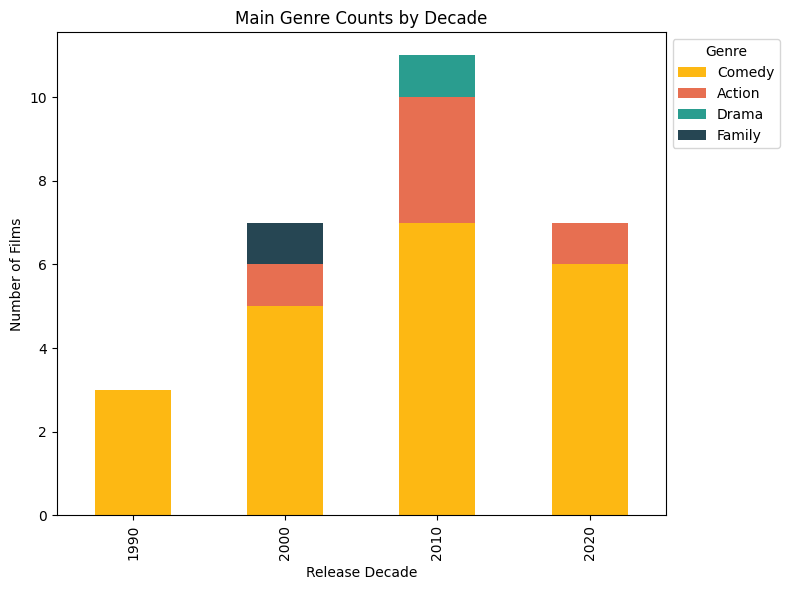

In [107]:
#Plotting main genre counts by decade
genre_order = ['Comedy', 'Action', 'Drama', 'Family']

genres_main_decade_count = genres_main_decade_count[genre_order]

genres_main_decade_count.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 6),
    color=['#FDB813', '#E76F51', '#2A9D8F', '#264653']  
)

plt.title('Main Genre Counts by Decade')
plt.xlabel('Release Decade')
plt.ylabel('Number of Films')
plt.legend(title='Genre', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

While comedy has always been a common theme for most of Pixar movies, Action has been the next most common being present in all decades since the 2000s. Family was introduced in one film in the 2000s, while Drama was present in one film in the 2010s.

In addition to the main genres, we will also look at the subgenres of the films, which are more unique

In [108]:
# Filter subgenres
genres_sub = genres[genres["category"] == "Subgenre"]

In [109]:
# One hot encode subgenres
genres_sub_dummies = pd.get_dummies(genres_sub['value'])

genres_sub_dummies['film'] = genres_sub['film']

genres_sub_matrix = genres_sub_dummies.groupby('film').max().reset_index()

genres_sub_matrix

,film,Adventure Epic,Animal Adventure,Artificial Intelligence,Buddy Comedy,Car Action,Coming-of-Age,Computer Animation,Crime,Dinosaur Adventure,...,Sport,Spy,Superhero,Supernatural Fantasy,Sword & Sorcery,Teen Adventure,Teen Comedy,Teen Drama,Time Travel,Urban Adventure
0,A Bug's Life,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Brave,False,False,False,False,False,True,True,False,False,...,False,False,False,False,True,True,False,False,False,False
2,Cars,False,False,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
3,Cars 2,False,False,False,False,True,False,True,True,False,...,True,True,False,False,False,False,False,False,False,False
4,Cars 3,False,False,False,False,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
5,Coco,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
6,Elemental,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
7,Finding Dory,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
8,Finding Nemo,False,True,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
9,Incredibles 2,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True


In [110]:
sub_genre_columns = genres_sub_matrix.columns.drop('film')
sub_genre_columns

Index(['Adventure Epic', 'Animal Adventure', 'Artificial Intelligence',
       'Buddy Comedy', 'Car Action', 'Coming-of-Age', 'Computer Animation',
       'Crime', 'Dinosaur Adventure', 'Dystopian Sci-Fi', 'Fairy Tale',
       'Fantasy', 'Fantasy Epic', 'Globetrotting Adventure', 'Motorsport',
       'Music', 'Mystery', 'Quest', 'Road Trip', 'Romance', 'Sci-Fi',
       'Sea Adventure', 'Space Sci-Fi', 'Sport', 'Spy', 'Superhero',
       'Supernatural Fantasy', 'Sword & Sorcery', 'Teen Adventure',
       'Teen Comedy', 'Teen Drama', 'Time Travel', 'Urban Adventure'],
      dtype='object')

In [111]:
# Extract count of subgenres
for sub_genre_column in sub_genre_columns:
    print(f"Number of {sub_genre_column} films: {genres_sub_matrix[sub_genre_column].sum()}")
    if genres_sub_matrix[sub_genre_column].sum() == 28:
        genres_sub_matrix = genres_sub_matrix.drop(sub_genre_column, axis=1)

Number of Adventure Epic films: 1
Number of Animal Adventure films: 5
Number of Artificial Intelligence films: 1
Number of Buddy Comedy films: 4
Number of Car Action films: 2
Number of Coming-of-Age films: 6
Number of Computer Animation films: 28
Number of Crime films: 1
Number of Dinosaur Adventure films: 1
Number of Dystopian Sci-Fi films: 1
Number of Fairy Tale films: 2
Number of Fantasy films: 14
Number of Fantasy Epic films: 1
Number of Globetrotting Adventure films: 1
Number of Motorsport films: 3
Number of Music films: 3
Number of Mystery films: 1
Number of Quest films: 6
Number of Road Trip films: 1
Number of Romance films: 1
Number of Sci-Fi films: 3
Number of Sea Adventure films: 3
Number of Space Sci-Fi films: 2
Number of Sport films: 3
Number of Spy films: 1
Number of Superhero films: 3
Number of Supernatural Fantasy films: 7
Number of Sword & Sorcery films: 2
Number of Teen Adventure films: 1
Number of Teen Comedy films: 2
Number of Teen Drama films: 1
Number of Time Trave

Similar to the main genres, as Computer Animation is a subgenre in all 28 films, we will not consider it for analysis.

In [112]:
#Join subgenres with decade
genres_sub_matrix_decade = genres_sub_matrix.merge(pixar_films[['film', 'release_decade']], on='film', how='inner')

In [113]:
genres_sub_matrix_decade

,film,Adventure Epic,Animal Adventure,Artificial Intelligence,Buddy Comedy,Car Action,Coming-of-Age,Crime,Dinosaur Adventure,Dystopian Sci-Fi,...,Spy,Superhero,Supernatural Fantasy,Sword & Sorcery,Teen Adventure,Teen Comedy,Teen Drama,Time Travel,Urban Adventure,release_decade
0,A Bug's Life,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1990
1,Brave,False,False,False,False,False,True,False,False,False,...,False,False,False,True,True,False,False,False,False,2010
2,Cars,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2000
3,Cars 2,False,False,False,False,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,2010
4,Cars 3,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2010
5,Coco,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,2010
6,Elemental,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,2020
7,Finding Dory,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2010
8,Finding Nemo,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2000
9,Incredibles 2,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,2010


In [114]:
sub_genre_columns_unique = genres_sub_matrix_decade.columns

sub_genre_columns_unique = sub_genre_columns_unique.drop(['film', 'release_decade'])

sub_genre_columns_unique

Index(['Adventure Epic', 'Animal Adventure', 'Artificial Intelligence',
       'Buddy Comedy', 'Car Action', 'Coming-of-Age', 'Crime',
       'Dinosaur Adventure', 'Dystopian Sci-Fi', 'Fairy Tale', 'Fantasy',
       'Fantasy Epic', 'Globetrotting Adventure', 'Motorsport', 'Music',
       'Mystery', 'Quest', 'Road Trip', 'Romance', 'Sci-Fi', 'Sea Adventure',
       'Space Sci-Fi', 'Sport', 'Spy', 'Superhero', 'Supernatural Fantasy',
       'Sword & Sorcery', 'Teen Adventure', 'Teen Comedy', 'Teen Drama',
       'Time Travel', 'Urban Adventure'],
      dtype='object')

In [115]:
#Count subgenres by decade
genres_sub_decade_count = genres_sub_matrix_decade.groupby('release_decade')[sub_genre_columns_unique].sum()

In [116]:
genres_sub_decade_count

,Adventure Epic,Animal Adventure,Artificial Intelligence,Buddy Comedy,Car Action,Coming-of-Age,Crime,Dinosaur Adventure,Dystopian Sci-Fi,Fairy Tale,...,Sport,Spy,Superhero,Supernatural Fantasy,Sword & Sorcery,Teen Adventure,Teen Comedy,Teen Drama,Time Travel,Urban Adventure
release_decade,,,,,,,,,,,,,,,,,,,,,
1990,0,1,0,1,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,2
2000,1,2,1,2,0,1,0,0,1,0,...,1,0,1,1,0,0,0,0,0,2
2010,0,2,0,1,2,2,1,1,0,1,...,2,1,1,3,1,1,0,0,0,3
2020,0,0,0,0,0,3,0,0,0,1,...,0,0,1,1,1,0,2,1,1,1


In [117]:
sorted_columns = genres_sub_decade_count.sum(axis=0).sort_values(ascending=False).index

genres_sub_decade_count = genres_sub_decade_count[sorted_columns]

In [118]:
genres_sub_decade_count

,Fantasy,Urban Adventure,Supernatural Fantasy,Coming-of-Age,Quest,Animal Adventure,Buddy Comedy,Music,Motorsport,Sea Adventure,...,Time Travel,Romance,Crime,Road Trip,Mystery,Globetrotting Adventure,Fantasy Epic,Dystopian Sci-Fi,Dinosaur Adventure,Adventure Epic
release_decade,,,,,,,,,,,,,,,,,,,,,
1990,2,2,2,0,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000,2,2,1,1,1,2,2,0,1,1,...,0,0,0,0,0,1,0,1,0,1
2010,6,3,3,2,1,2,1,1,2,1,...,0,0,1,1,1,0,0,0,1,0
2020,4,1,1,3,2,0,0,2,0,1,...,1,1,0,0,0,0,1,0,0,0


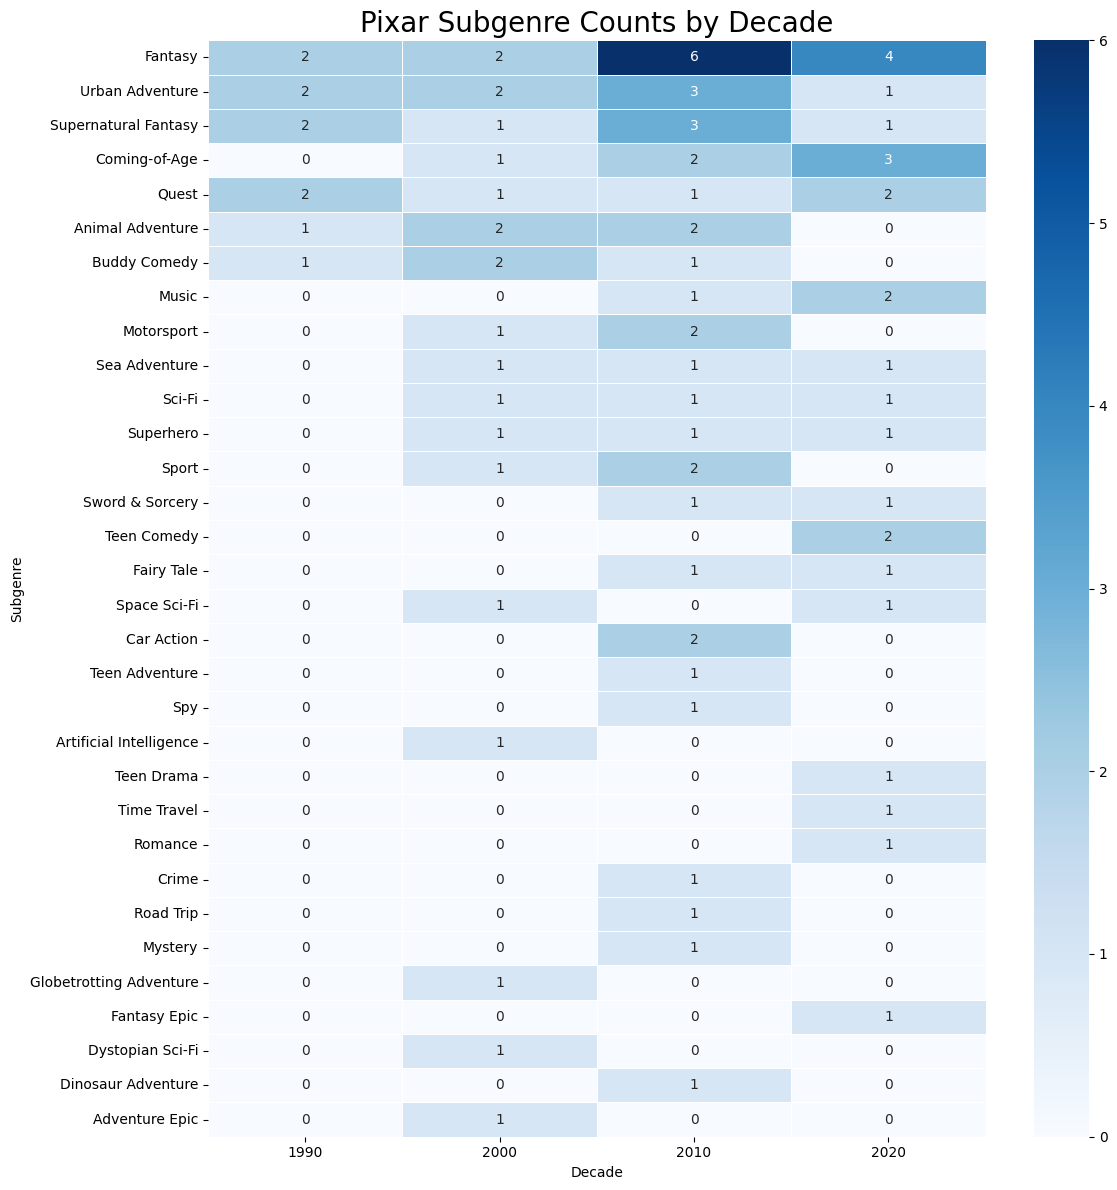

In [119]:
#Plotting sub genres by decade
genres_sub_decade_count_heatmap = genres_sub_decade_count.T

plt.figure(figsize=(12, 12))  
sns.heatmap(genres_sub_decade_count_heatmap, cmap='Blues', annot=True, fmt='g', linewidths=0.5)
plt.title("Pixar Subgenre Counts by Decade", fontsize=20)
plt.xlabel("Decade")
plt.ylabel("Subgenre")

plt.tight_layout()
plt.show()


Key insights from subgenres:

* Staring from only a few main subgenres, more subgenres have emerged over time, peaking in terms of diversity in the 2010s
* Fantasy is the most common subgenre, being present in 14/28 films in all decades, with more present in later decades
* This is then followed by Urban Adventure and Supernatural Fantasy, peaking at the 2010s while not much present in the 2020s
* Coming-of-Age being more present over time, showing Pixar films' evolution as Pixar films' audience age over time
* New genres introduced in the 2020s (Romance, Teen Comedy, Teen Drama, etc.) also show the evolution of Pixar's films towards being more mature


## Filter most common subgenres for model fitting

With the exception of Computer Animation, there are 32 subgenres, which is a large number. Therefore, for model fitting, only subgenres present in 4 or more films are kept. For the other subgenres, we will denote as other.

In [120]:
# Keep only main subgenres, while encoding other subgenres as other
genres_sub_matrix_shorten = genres_sub_matrix
main_sub_genres = ['Fantasy', 'Urban Adventure', 'Supernatural Fantasy', 'Coming-of-Age', 'Quest', 'Animal Adventure', 'Buddy Comedy']
other_sub_genres = [col for col in genres_sub_matrix.columns if col not in main_sub_genres]
other_sub_genres.remove('film')
genres_sub_matrix_shorten['Other'] = genres_sub_matrix_shorten[other_sub_genres].max(axis=1)
genres_sub_matrix_shorten.drop(columns=other_sub_genres, inplace=True)

In [121]:
genres_sub_matrix_shorten.head()

,film,Animal Adventure,Buddy Comedy,Coming-of-Age,Fantasy,Quest,Supernatural Fantasy,Urban Adventure,Other
0,A Bug's Life,True,False,False,False,True,False,False,False
1,Brave,False,False,True,False,True,False,False,True
2,Cars,False,False,False,False,False,False,False,True
3,Cars 2,False,False,False,False,False,False,False,True
4,Cars 3,False,False,False,False,False,False,False,True


## Personnel Analysis

In [122]:
# Filter different roles people can take in Pixar
person_roles = pixar_people['role_type'].unique()

In [123]:
person_roles

array(['Director', 'Musician', 'Producer', 'Screenwriter', 'Storywriter',
       'Co-director'], dtype=object)

In [124]:
# Replace Co-director as Director role
pixar_people['role_type'] = pixar_people['role_type'].replace('Co-director', 'Director')

### Who has taken part in most Pixar movies?

In [125]:
top_people = pixar_people.groupby('name').film.nunique().sort_values(ascending=False)

In [126]:
top_people_df = top_people.reset_index(name='film_count')

In [127]:
top_people_df.head(10)

,name,film_count
0,Randy Newman,9
1,Andrew Stanton,9
2,Michael Giacchino,8
3,Pete Docter,7
4,John Lasseter,7
5,Darla K. Anderson,5
6,Lee Unkrich,5
7,Bob Peterson,4
8,Thomas Newman,4
9,Jonas Rivera,3


The 2 people contributing to the most Pixar films are Randy Newman and Andrew Stanton, each with 9 films.
This is then followed by Michael Giacchino with 8 films, and Pete Docter and John Lasseter each with 7.

### How about people by their roles?

In [128]:
role_counts = pixar_people.groupby(['role_type','name']).film.nunique()

In [129]:
role_counts_df = role_counts.reset_index(name='film_count')
role_counts_df = role_counts_df.sort_values(by='film_count', ascending=False)

In [130]:
role_counts_df.head(15)

,role_type,name,film_count
31,Musician,Randy Newman,9
29,Musician,Michael Giacchino,8
56,Screenwriter,Andrew Stanton,8
100,Storywriter,Andrew Stanton,8
139,Storywriter,Pete Docter,7
124,Storywriter,John Lasseter,7
14,Director,John Lasseter,5
37,Producer,Darla K. Anderson,5
18,Director,Lee Unkrich,5
1,Director,Andrew Stanton,4


In all 9 films, Randy Newman was the musician for the films.
Similarly, Michael Giacchino was the musician for all the 8 films he contributed.
Andrew Stanton played different roles, with the most being as a screenwriter or storywriter for 8 times each.
Pete Docter and John Lasseter were the storywriter for all 7 films they worked on. In addition, both people were also the director for many of their movies.

### Personnel Analysis By Decade

In [131]:
# Merge personnel data with film's release decade
pixar_people_decade = pixar_people.merge(pixar_films[['film', 'release_decade']], on='film', how='inner')

In [132]:
pixar_people_decade.head()

,film,role_type,name,release_decade
0,Toy Story,Director,John Lasseter,1990
1,Toy Story,Musician,Randy Newman,1990
2,Toy Story,Producer,Bonnie Arnold,1990
3,Toy Story,Producer,Ralph Guggenheim,1990
4,Toy Story,Screenwriter,Joel Cohen,1990


In [133]:
# Count each person according to the decades they worked on
person_decade_counts = pixar_people_decade.drop_duplicates(['film', 'name']).groupby(['name', 'release_decade'])['film'].nunique().unstack(fill_value=0)

In [134]:
# Sum total of films each person contributed to, and sort this total
person_decade_counts['total'] = person_decade_counts.sum(axis=1)
person_decade_counts = person_decade_counts.sort_values('total', ascending=False)

In [135]:
person_decade_counts.head(15)

release_decade,1990,2000,2010,2020,total
name,,,,,
Randy Newman,3,2,4,0,9
Andrew Stanton,3,3,3,0,9
Michael Giacchino,0,3,4,1,8
Pete Docter,2,3,1,1,7
John Lasseter,3,1,3,0,7
Darla K. Anderson,1,2,2,0,5
Lee Unkrich,1,2,2,0,5
Bob Peterson,0,2,2,0,4
Thomas Newman,0,2,1,1,4


#### 1990s Personnel

In [136]:
# Extract people contributing to Pixar films in the 1990s
top_1990 = person_decade_counts[1990].sort_values(ascending=False)
top_1990_df = top_1990.reset_index()
top_1990_df.columns = ['name', 'film_count']
top_1990_df = top_1990_df[top_1990_df['film_count'] > 0]

In [137]:
# Extract people responsible for multiple films in the 1990s
top_1990_df[top_1990_df['film_count'] > 1]

,name,film_count
0,Randy Newman,3
1,John Lasseter,3
2,Andrew Stanton,3
3,Pete Docter,2
4,Joe Ranft,2


#### 2000s Personnel

In [138]:
# Extract people contributing to Pixar films in the 2000s
top_2000 = person_decade_counts[2000].sort_values(ascending=False)
top_2000_df = top_2000.reset_index()
top_2000_df.columns = ['name', 'film_count']
top_2000_df = top_2000_df[top_2000_df['film_count'] > 0]

In [139]:
# Extract people responsible for multiple films in the 2000s
top_2000_df[top_2000_df['film_count'] > 1]

,name,film_count
0,Michael Giacchino,3
1,Pete Docter,3
2,Andrew Stanton,3
3,Randy Newman,2
4,Brad Bird,2
5,Darla K. Anderson,2
6,Lee Unkrich,2
7,Bob Peterson,2
8,Thomas Newman,2


In [140]:
top_2010 = person_decade_counts[2010].sort_values(ascending=False)
top_2010_df = top_2010.reset_index()
top_2010_df.columns = ['name', 'film_count']
top_2010_df = top_2010_df[top_2010_df['film_count'] > 0]

In [141]:
top_2010_df[top_2010_df['film_count'] > 1]

,name,film_count
0,Randy Newman,4
1,Michael Giacchino,4
2,Andrew Stanton,3
3,John Lasseter,3
4,Ben Queen,2
5,Meg LeFauve,2
6,Denise Ream,2
7,Jonas Rivera,2
8,Josh Cooley,2
9,Bob Peterson,2


In [142]:
top_2020 = person_decade_counts[2020].sort_values(ascending=False)
top_2020_df = top_2020.reset_index()
top_2020_df.columns = ['name', 'film_count']
top_2020_df = top_2020_df[top_2020_df['film_count'] > 0]

In [143]:
top_2020_df[top_2020_df['film_count'] > 1]

,name,film_count
0,Jason Headley,2


### Personnel Analysis By Academy Awards Won

In [144]:
pixar_people_awards_won = pixar_people.merge(awards_won_counts_df, on='film', how='inner')

In [145]:
pixar_people_awards_won = pixar_people_awards_won[pixar_people_awards_won['num_awards_won'] > 0]

In [146]:
pixar_people_awards_won.head()

,film,role_type,name,num_awards_won
0,Toy Story,Director,John Lasseter,1
1,Toy Story,Musician,Randy Newman,1
2,Toy Story,Producer,Bonnie Arnold,1
3,Toy Story,Producer,Ralph Guggenheim,1
4,Toy Story,Screenwriter,Joel Cohen,1


In [147]:
unique_awards = pixar_people_awards_won.drop_duplicates(subset=['film', 'name'])
awards_won_by_person = unique_awards.groupby('name')['num_awards_won'].sum().reset_index()
awards_won_by_person = awards_won_by_person.sort_values(by='num_awards_won', ascending=False)

In [148]:
awards_won_by_person.head(10)

,name,num_awards_won
38,Pete Docter,8
36,Michael Giacchino,8
2,Andrew Stanton,7
29,Lee Unkrich,6
41,Randy Newman,5
10,Darla K. Anderson,5
23,John Lasseter,4
25,Jonas Rivera,4
6,Brad Bird,3
4,Bob Peterson,3


In [149]:
awards_won_by_person_role = pixar_people_awards_won.groupby(['name', 'role_type'])['num_awards_won'].sum().reset_index()
awards_won_by_person_role = awards_won_by_person_role.sort_values(by='num_awards_won', ascending=False)

In [150]:
awards_won_by_person_role.head(10)

,name,role_type,num_awards_won
56,Michael Giacchino,Musician,8
61,Pete Docter,Storywriter,8
43,Lee Unkrich,Director,6
59,Pete Docter,Director,6
6,Andrew Stanton,Storywriter,6
64,Randy Newman,Musician,5
18,Darla K. Anderson,Producer,5
60,Pete Docter,Screenwriter,5
5,Andrew Stanton,Screenwriter,5
44,Lee Unkrich,Storywriter,4


## Filter Out Most Common Roles For Model Fitting

In [151]:
filtered_role_counts_df = role_counts_df[role_counts_df['film_count'] >= 4]

filtered_role_counts_df

,role_type,name,film_count
31,Musician,Randy Newman,9
29,Musician,Michael Giacchino,8
56,Screenwriter,Andrew Stanton,8
100,Storywriter,Andrew Stanton,8
139,Storywriter,Pete Docter,7
124,Storywriter,John Lasseter,7
14,Director,John Lasseter,5
37,Producer,Darla K. Anderson,5
18,Director,Lee Unkrich,5
1,Director,Andrew Stanton,4


In [152]:
filtered_people = pixar_people.merge(filtered_role_counts_df[['role_type', 'name']], on=['role_type', 'name'], how='inner')

In [153]:
filtered_people.head()

,film,role_type,name
0,Toy Story,Director,John Lasseter
1,Toy Story,Musician,Randy Newman
2,Toy Story,Screenwriter,Andrew Stanton
3,Toy Story,Storywriter,Pete Docter
4,Toy Story,Storywriter,John Lasseter


In [154]:
filtered_people['person_role'] = filtered_people['name'] + '_' + filtered_people['role_type']

In [155]:
filtered_people_dummies = pd.get_dummies(filtered_people['person_role'])

filtered_people_dummies['film'] = filtered_people['film']

filtered_people_matrix = filtered_people_dummies.groupby('film').max().reset_index()

filtered_people_matrix

,film,Andrew Stanton_Director,Andrew Stanton_Screenwriter,Andrew Stanton_Storywriter,Darla K. Anderson_Producer,John Lasseter_Director,John Lasseter_Storywriter,Lee Unkrich_Director,Michael Giacchino_Musician,Pete Docter_Director,Pete Docter_Storywriter,Randy Newman_Musician,Thomas Newman_Musician
0,A Bug's Life,True,True,True,True,True,True,False,False,False,False,True,False
1,Cars,False,False,False,True,True,True,False,False,False,False,True,False
2,Cars 2,False,False,False,False,True,True,False,True,False,False,False,False
3,Cars 3,False,False,False,False,False,False,False,False,False,False,True,False
4,Coco,False,False,False,True,False,False,True,True,False,False,False,False
5,Elemental,False,False,False,False,False,False,False,False,False,False,False,True
6,Finding Dory,True,True,True,False,False,False,False,False,False,False,False,True
7,Finding Nemo,True,True,True,False,False,False,True,False,False,False,False,True
8,Incredibles 2,False,False,False,False,False,False,False,True,False,False,False,False
9,Inside Out,False,False,False,False,False,False,False,True,True,True,False,False


### Predict Films' Box Office Revenue

In [156]:
pixar_full = pixar_films.merge(box_office[['film', 'budget', 'box_office_worldwide']], on='film', how='inner')

In [157]:
pixar_full.head()

,number,film,release_date,run_time,film_rating,plot,release_month,release_quarter,release_year,release_decade,budget,box_office_worldwide
0,1,Toy Story,1995-11-22,81,G,A cowboy doll is profoundly threatened and jea...,11,4,1995,1990,30000000.0,394436586
1,2,A Bug's Life,1998-11-25,95,G,"A misfit ant, looking for ""warriors"" to save h...",11,4,1998,1990,120000000.0,363258859
2,3,Toy Story 2,1999-11-24,92,G,"When Woody is stolen by a toy collector, Buzz ...",11,4,1999,1990,90000000.0,511358276
3,4,"Monsters, Inc.",2001-11-02,92,G,"In order to power the city, monsters have to s...",11,4,2001,2000,115000000.0,528773250
4,5,Finding Nemo,2003-05-30,100,G,After his son is captured in the Great Barrier...,5,2,2003,2000,94000000.0,871014978


In [158]:
pixar_full.isna().sum()

number                  0
film                    0
release_date            0
run_time                0
film_rating             0
plot                    0
release_month           0
release_quarter         0
release_year            0
release_decade          0
budget                  0
box_office_worldwide    0
dtype: int64

In [159]:
pixar_full.dtypes

number                           int64
film                            object
release_date            datetime64[ns]
run_time                         int64
film_rating                     object
plot                            object
release_month                    int32
release_quarter                  int32
release_year                     int32
release_decade                   int32
budget                         float64
box_office_worldwide             int64
dtype: object

In [160]:
pixar_full.astype({'box_office_worldwide': 'float64'}).dtypes

number                           int64
film                            object
release_date            datetime64[ns]
run_time                         int64
film_rating                     object
plot                            object
release_month                    int32
release_quarter                  int32
release_year                     int32
release_decade                   int32
budget                         float64
box_office_worldwide           float64
dtype: object

In [161]:
pixar_full['release_month_sin'] = np.sin(2 * np.pi * pixar_full['release_month'] / 12)
pixar_full['release_month_cos'] = np.cos(2 * np.pi * pixar_full['release_month'] / 12)
pixar_full['release_quarter_sin'] = np.sin(2 * np.pi * pixar_full['release_quarter'] / 4)
pixar_full['release_quarter_cos'] = np.cos(2 * np.pi * pixar_full['release_quarter'] / 4)

In [162]:
pixar_full['release_decade_1990'] = pixar_full['release_decade'] == 1990
pixar_full['release_decade_2000'] = pixar_full['release_decade'] == 2000
pixar_full['release_decade_2010'] = pixar_full['release_decade'] == 2010
pixar_full['release_decade_2020'] = pixar_full['release_decade'] == 2020

In [163]:
pixar_full.head()

,number,film,release_date,run_time,film_rating,plot,release_month,release_quarter,release_year,release_decade,budget,box_office_worldwide,release_month_sin,release_month_cos,release_quarter_sin,release_quarter_cos,release_decade_1990,release_decade_2000,release_decade_2010,release_decade_2020
0,1,Toy Story,1995-11-22,81,G,A cowboy doll is profoundly threatened and jea...,11,4,1995,1990,30000000.0,394436586,-0.5,0.866025,-2.449294e-16,1.0,True,False,False,False
1,2,A Bug's Life,1998-11-25,95,G,"A misfit ant, looking for ""warriors"" to save h...",11,4,1998,1990,120000000.0,363258859,-0.5,0.866025,-2.449294e-16,1.0,True,False,False,False
2,3,Toy Story 2,1999-11-24,92,G,"When Woody is stolen by a toy collector, Buzz ...",11,4,1999,1990,90000000.0,511358276,-0.5,0.866025,-2.449294e-16,1.0,True,False,False,False
3,4,"Monsters, Inc.",2001-11-02,92,G,"In order to power the city, monsters have to s...",11,4,2001,2000,115000000.0,528773250,-0.5,0.866025,-2.449294e-16,1.0,False,True,False,False
4,5,Finding Nemo,2003-05-30,100,G,After his son is captured in the Great Barrier...,5,2,2003,2000,94000000.0,871014978,0.5,-0.866025,1.224647e-16,-1.0,False,True,False,False


In [164]:
pixar_full = pixar_full.merge(public_response, on='film', how='inner')

In [165]:
pixar_full.head()

,number,film,release_date,run_time,film_rating,plot,release_month,release_quarter,release_year,release_decade,...,release_decade_2000,release_decade_2010,release_decade_2020,rotten_tomatoes_score,rotten_tomatoes_counts,metacritic_score,metacritic_counts,cinema_score,imdb_score,imdb_counts
0,1,Toy Story,1995-11-22,81,G,A cowboy doll is profoundly threatened and jea...,11,4,1995,1990,...,False,False,False,100.0,96,95.0,26,3.7,8.3,1089101
1,2,A Bug's Life,1998-11-25,95,G,"A misfit ant, looking for ""warriors"" to save h...",11,4,1998,1990,...,False,False,False,92.0,91,78.0,23,3.7,7.2,319596
2,3,Toy Story 2,1999-11-24,92,G,"When Woody is stolen by a toy collector, Buzz ...",11,4,1999,1990,...,False,False,False,100.0,172,88.0,34,4.0,7.9,630573
3,4,"Monsters, Inc.",2001-11-02,92,G,"In order to power the city, monsters have to s...",11,4,2001,2000,...,True,False,False,96.0,199,79.0,35,4.0,8.1,1000657
4,5,Finding Nemo,2003-05-30,100,G,After his son is captured in the Great Barrier...,5,2,2003,2000,...,True,False,False,99.0,270,90.0,38,4.0,8.2,1132877


In [166]:
pixar_full = pixar_full.merge(genres_main_matrix, on='film', how='inner')

In [167]:
pixar_full.head()

,number,film,release_date,run_time,film_rating,plot,release_month,release_quarter,release_year,release_decade,...,rotten_tomatoes_counts,metacritic_score,metacritic_counts,cinema_score,imdb_score,imdb_counts,Action,Comedy,Drama,Family
0,1,Toy Story,1995-11-22,81,G,A cowboy doll is profoundly threatened and jea...,11,4,1995,1990,...,96,95.0,26,3.7,8.3,1089101,False,True,False,False
1,2,A Bug's Life,1998-11-25,95,G,"A misfit ant, looking for ""warriors"" to save h...",11,4,1998,1990,...,91,78.0,23,3.7,7.2,319596,False,True,False,False
2,3,Toy Story 2,1999-11-24,92,G,"When Woody is stolen by a toy collector, Buzz ...",11,4,1999,1990,...,172,88.0,34,4.0,7.9,630573,False,True,False,False
3,4,"Monsters, Inc.",2001-11-02,92,G,"In order to power the city, monsters have to s...",11,4,2001,2000,...,199,79.0,35,4.0,8.1,1000657,False,True,False,False
4,5,Finding Nemo,2003-05-30,100,G,After his son is captured in the Great Barrier...,5,2,2003,2000,...,270,90.0,38,4.0,8.2,1132877,False,True,False,False


In [168]:
pixar_full.rename(columns={'Action': 'main_genre_action', 'Comedy': 'main_genre_comedy', 'Drama': 'main_genre_drama', 'Family': 'main_genre_family'}, inplace=True)

In [169]:
pixar_full = pixar_full.merge(genres_sub_matrix_shorten, on='film', how='inner')

In [170]:
pixar_full.head()

,number,film,release_date,run_time,film_rating,plot,release_month,release_quarter,release_year,release_decade,...,main_genre_drama,main_genre_family,Animal Adventure,Buddy Comedy,Coming-of-Age,Fantasy,Quest,Supernatural Fantasy,Urban Adventure,Other
0,1,Toy Story,1995-11-22,81,G,A cowboy doll is profoundly threatened and jea...,11,4,1995,1990,...,False,False,False,True,False,True,False,True,True,False
1,2,A Bug's Life,1998-11-25,95,G,"A misfit ant, looking for ""warriors"" to save h...",11,4,1998,1990,...,False,False,True,False,False,False,True,False,False,False
2,3,Toy Story 2,1999-11-24,92,G,"When Woody is stolen by a toy collector, Buzz ...",11,4,1999,1990,...,False,False,False,False,False,True,True,True,True,False
3,4,"Monsters, Inc.",2001-11-02,92,G,"In order to power the city, monsters have to s...",11,4,2001,2000,...,False,False,False,True,False,True,False,True,True,False
4,5,Finding Nemo,2003-05-30,100,G,After his son is captured in the Great Barrier...,5,2,2003,2000,...,False,False,True,True,False,False,True,False,False,True


In [171]:
pixar_full.rename(columns={'Animal Adventure': 'sub_genre_animal_adventure', 'Buddy Comedy': 'sub_genre_buddy_comedy', 'Coming-of-Age': 'sub_genre_coming_of_age', 'Fantasy': 'sub_genre_fantasy', 'Quest': 'sub_genre_quest', 'Supernatural Fantasy': 'sub_genre_supernatural_fantasy', 'Urban Adventure': 'sub_genre_urban_adventure', 'Other': 'sub_genre_other'}, inplace=True)

In [172]:
pixar_full = pixar_full.merge(filtered_people_matrix, on='film', how='left')

In [173]:
pixar_full.head()

,number,film,release_date,run_time,film_rating,plot,release_month,release_quarter,release_year,release_decade,...,Andrew Stanton_Storywriter,Darla K. Anderson_Producer,John Lasseter_Director,John Lasseter_Storywriter,Lee Unkrich_Director,Michael Giacchino_Musician,Pete Docter_Director,Pete Docter_Storywriter,Randy Newman_Musician,Thomas Newman_Musician
0,1,Toy Story,1995-11-22,81,G,A cowboy doll is profoundly threatened and jea...,11,4,1995,1990,...,True,False,True,True,False,False,False,True,True,False
1,2,A Bug's Life,1998-11-25,95,G,"A misfit ant, looking for ""warriors"" to save h...",11,4,1998,1990,...,True,True,True,True,False,False,False,False,True,False
2,3,Toy Story 2,1999-11-24,92,G,"When Woody is stolen by a toy collector, Buzz ...",11,4,1999,1990,...,True,False,True,True,True,False,False,True,True,False
3,4,"Monsters, Inc.",2001-11-02,92,G,"In order to power the city, monsters have to s...",11,4,2001,2000,...,False,True,False,False,True,False,True,True,True,False
4,5,Finding Nemo,2003-05-30,100,G,After his son is captured in the Great Barrier...,5,2,2003,2000,...,True,False,False,False,True,False,False,False,False,True


In [174]:
pixar_full.isna().sum()

number                            0
film                              0
release_date                      0
run_time                          0
film_rating                       0
plot                              0
release_month                     0
release_quarter                   0
release_year                      0
release_decade                    0
budget                            0
box_office_worldwide              0
release_month_sin                 0
release_month_cos                 0
release_quarter_sin               0
release_quarter_cos               0
release_decade_1990               0
release_decade_2000               0
release_decade_2010               0
release_decade_2020               0
rotten_tomatoes_score             0
rotten_tomatoes_counts            0
metacritic_score                  0
metacritic_counts                 0
cinema_score                      0
imdb_score                        0
imdb_counts                       0
main_genre_action           

In [175]:
pixar_full[filtered_people_matrix.columns] = pixar_full[filtered_people_matrix.columns].fillna(False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39644\4089207650.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pixar_full[filtered_people_matrix.columns] = pixar_full[filtered_people_matrix.columns].fillna(False)


In [176]:
pixar_full.isna().sum()

number                            0
film                              0
release_date                      0
run_time                          0
film_rating                       0
plot                              0
release_month                     0
release_quarter                   0
release_year                      0
release_decade                    0
budget                            0
box_office_worldwide              0
release_month_sin                 0
release_month_cos                 0
release_quarter_sin               0
release_quarter_cos               0
release_decade_1990               0
release_decade_2000               0
release_decade_2010               0
release_decade_2020               0
rotten_tomatoes_score             0
rotten_tomatoes_counts            0
metacritic_score                  0
metacritic_counts                 0
cinema_score                      0
imdb_score                        0
imdb_counts                       0
main_genre_action           

In [177]:
pixar_full.head()

,number,film,release_date,run_time,film_rating,plot,release_month,release_quarter,release_year,release_decade,...,Andrew Stanton_Storywriter,Darla K. Anderson_Producer,John Lasseter_Director,John Lasseter_Storywriter,Lee Unkrich_Director,Michael Giacchino_Musician,Pete Docter_Director,Pete Docter_Storywriter,Randy Newman_Musician,Thomas Newman_Musician
0,1,Toy Story,1995-11-22,81,G,A cowboy doll is profoundly threatened and jea...,11,4,1995,1990,...,True,False,True,True,False,False,False,True,True,False
1,2,A Bug's Life,1998-11-25,95,G,"A misfit ant, looking for ""warriors"" to save h...",11,4,1998,1990,...,True,True,True,True,False,False,False,False,True,False
2,3,Toy Story 2,1999-11-24,92,G,"When Woody is stolen by a toy collector, Buzz ...",11,4,1999,1990,...,True,False,True,True,True,False,False,True,True,False
3,4,"Monsters, Inc.",2001-11-02,92,G,"In order to power the city, monsters have to s...",11,4,2001,2000,...,False,True,False,False,True,False,True,True,True,False
4,5,Finding Nemo,2003-05-30,100,G,After his son is captured in the Great Barrier...,5,2,2003,2000,...,True,False,False,False,True,False,False,False,False,True


In [178]:
# Add variable indicating sequels

pixar_full['is_sequel'] = 0

sequel_films = [
    'Toy Story 2', 'Toy Story 3', 'Toy Story 4',
    'Cars 2', 'Cars 3', 'Inside Out 2'
]

pixar_full.loc[pixar_full['film'].isin(sequel_films), 'is_sequel'] = 1

In [179]:
pixar_full['log_box_office_worldwide'] = np.log(pixar_full['box_office_worldwide'])

In [180]:
pixar_full['log_budget'] = np.log(pixar_full['budget'])

In [181]:
pixar_full = pixar_full.drop(['budget', 'box_office_worldwide', 'number', 'film', 'release_date', 'film_rating', 'plot', 'release_month', 'release_quarter', 'release_decade', 'rotten_tomatoes_counts', 'metacritic_counts', 'imdb_counts'], axis=1)

In [182]:
pixar_full.columns

Index(['run_time', 'release_year', 'release_month_sin', 'release_month_cos',
       'release_quarter_sin', 'release_quarter_cos', 'release_decade_1990',
       'release_decade_2000', 'release_decade_2010', 'release_decade_2020',
       'rotten_tomatoes_score', 'metacritic_score', 'cinema_score',
       'imdb_score', 'main_genre_action', 'main_genre_comedy',
       'main_genre_drama', 'main_genre_family', 'sub_genre_animal_adventure',
       'sub_genre_buddy_comedy', 'sub_genre_coming_of_age',
       'sub_genre_fantasy', 'sub_genre_quest',
       'sub_genre_supernatural_fantasy', 'sub_genre_urban_adventure',
       'sub_genre_other', 'Andrew Stanton_Director',
       'Andrew Stanton_Screenwriter', 'Andrew Stanton_Storywriter',
       'Darla K. Anderson_Producer', 'John Lasseter_Director',
       'John Lasseter_Storywriter', 'Lee Unkrich_Director',
       'Michael Giacchino_Musician', 'Pete Docter_Director',
       'Pete Docter_Storywriter', 'Randy Newman_Musician',
       'Thomas Newman

In [183]:
pixar_full.head()

,run_time,release_year,release_month_sin,release_month_cos,release_quarter_sin,release_quarter_cos,release_decade_1990,release_decade_2000,release_decade_2010,release_decade_2020,...,John Lasseter_Storywriter,Lee Unkrich_Director,Michael Giacchino_Musician,Pete Docter_Director,Pete Docter_Storywriter,Randy Newman_Musician,Thomas Newman_Musician,is_sequel,log_box_office_worldwide,log_budget
0,81,1995,-0.5,0.866025,-2.449294e-16,1.0,True,False,False,False,...,True,False,False,False,True,True,False,0,19.792969,17.216708
1,95,1998,-0.5,0.866025,-2.449294e-16,1.0,True,False,False,False,...,True,False,False,False,False,True,False,0,19.710626,18.603002
2,92,1999,-0.5,0.866025,-2.449294e-16,1.0,True,False,False,False,...,True,True,False,False,True,True,False,1,20.052581,18.315320
3,92,2001,-0.5,0.866025,-2.449294e-16,1.0,False,True,False,False,...,False,True,False,True,True,True,False,0,20.086070,18.560443
4,100,2003,0.5,-0.866025,1.224647e-16,-1.0,False,True,False,False,...,False,True,False,False,False,False,True,0,20.585170,18.358805


In [184]:
pixar_full.columns = pixar_full.columns.str.replace(' ', '_')

In [185]:
pixar_full = pixar_full.rename(columns={'Darla_K._Anderson_Producer': 'Darla_K_Anderson_Producer'})

In [186]:
pixar_full = pixar_full.replace({True: 1, False: 0})

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39644\106019395.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pixar_full = pixar_full.replace({True: 1, False: 0})


In [187]:
#Generate interaction terms
pixar_full['log_budget_Andrew_Stanton_Director'] = pixar_full['log_budget'] * pixar_full['Andrew_Stanton_Director']
pixar_full['log_budget_Pete_Docter_Director'] = pixar_full['log_budget'] * pixar_full['Pete_Docter_Director']
pixar_full['log_budget_Andrew_Stanton_Director'] = pixar_full['log_budget'] * pixar_full['Andrew_Stanton_Director']
pixar_full['log_budget_rotten_tomatoes_score'] = pixar_full['log_budget'] * pixar_full['rotten_tomatoes_score']
pixar_full['log_budget_metacritic_score'] = pixar_full['log_budget'] * pixar_full['metacritic_score']
pixar_full['log_budget_cinema_score'] = pixar_full['log_budget'] * pixar_full['cinema_score']
pixar_full['log_budget_imdb_score'] = pixar_full['log_budget'] * pixar_full['imdb_score']
pixar_full['release_month_sin_main_genre_family'] = pixar_full['release_month_sin'] * pixar_full['main_genre_family']
pixar_full['release_quarter_sin_main_genre_family'] = pixar_full['release_quarter_sin'] * pixar_full['main_genre_family']
pixar_full['release_month_cos_main_genre_action'] = pixar_full['release_month_cos'] * pixar_full['main_genre_action']
pixar_full['release_quarter_cos_main_genre_action'] = pixar_full['release_quarter_cos'] * pixar_full['main_genre_action']
pixar_full['release_decade_2010_main_genre_comedy'] = pixar_full['release_decade_2010'] * pixar_full['main_genre_comedy']
pixar_full['release_decade_2010_sub_genre_fantasy'] = pixar_full['release_decade_2010'] * pixar_full['sub_genre_fantasy']
pixar_full['release_decade_2020_sub_genre_fantasy'] = pixar_full['release_decade_2020'] * pixar_full['sub_genre_fantasy']
pixar_full['release_decade_2020_sub_genre_coming_of_age'] = pixar_full['release_decade_2020'] * pixar_full['sub_genre_coming_of_age']
pixar_full['release_year_log_budget'] = pixar_full['release_year'] * pixar_full['log_budget']
pixar_full['rotten_tomatoes_score_metacritic_score'] = pixar_full['rotten_tomatoes_score'] * pixar_full['metacritic_score']
pixar_full['rotten_tomatoes_score_main_genre_drama'] = pixar_full['rotten_tomatoes_score'] * pixar_full['main_genre_drama']
pixar_full['imdb_score_sub_genre_coming_of_age'] = pixar_full['imdb_score'] * pixar_full['sub_genre_coming_of_age']
pixar_full['main_genre_comedy_sub_genre_buddy_comedy'] = pixar_full['main_genre_comedy'] * pixar_full['sub_genre_buddy_comedy']
pixar_full['main_genre_action_run_time'] = pixar_full['main_genre_action'] * pixar_full['run_time']
pixar_full['log_budget_sub_genre_fantasy'] = pixar_full['log_budget'] * pixar_full['sub_genre_fantasy']

In [188]:
#Correlation between log of box office revenue and other variables
pixar_full.corr()['log_box_office_worldwide'].sort_values(key=abs, ascending=False)

log_box_office_worldwide                       1.000000
release_decade_2020_sub_genre_fantasy         -0.701560
release_quarter_sin                           -0.620873
release_decade_2020                           -0.614508
release_decade_2020_sub_genre_coming_of_age   -0.480391
release_decade_2010                            0.401452
release_decade_2010_sub_genre_fantasy          0.393794
release_month_sin                             -0.380224
log_budget_cinema_score                        0.349078
release_decade_2010_main_genre_comedy          0.325391
log_budget_imdb_score                          0.325271
cinema_score                                   0.321095
is_sequel                                      0.296186
imdb_score                                     0.293965
sub_genre_urban_adventure                      0.275429
release_month_cos                             -0.260392
Andrew_Stanton_Storywriter                     0.259068
release_year                                  -0

In [189]:
#Full correlation table
pixar_full.corr()

,run_time,release_year,release_month_sin,release_month_cos,release_quarter_sin,release_quarter_cos,release_decade_1990,release_decade_2000,release_decade_2010,release_decade_2020,...,release_decade_2010_sub_genre_fantasy,release_decade_2020_sub_genre_fantasy,release_decade_2020_sub_genre_coming_of_age,release_year_log_budget,rotten_tomatoes_score_metacritic_score,rotten_tomatoes_score_main_genre_drama,imdb_score_sub_genre_coming_of_age,main_genre_comedy_sub_genre_buddy_comedy,main_genre_action_run_time,log_budget_sub_genre_fantasy
run_time,1.000000,0.223079,0.159043,-0.300367,2.130803e-02,-0.298278,-0.484787,2.635280e-01,0.108067,-3.913782e-02,...,0.018094,-7.195401e-02,-0.148724,0.347994,-0.181422,0.112195,-0.302300,-0.411730,0.320736,-0.248729
release_year,0.223079,1.000000,0.447497,-0.397039,2.959529e-01,-0.401276,-0.638386,-4.893106e-01,0.246941,6.667807e-01,...,0.171994,4.607289e-01,0.426435,0.821202,-0.420544,0.110708,0.299228,-0.539002,0.103143,0.070378
release_month_sin,0.159043,0.447497,1.000000,-0.447382,7.253646e-01,-0.479705,-0.429148,2.649065e-02,-0.150989,4.503410e-01,...,-0.087860,2.809757e-01,0.312590,0.383972,-0.072478,-0.238416,0.351890,-0.132453,-0.215058,-0.125396
release_month_cos,-0.300367,-0.397039,-0.447382,1.000000,1.260524e-01,0.998668,0.515242,-3.271117e-02,-0.268298,-3.271117e-02,...,-0.191795,6.381738e-02,-0.117997,-0.547614,0.260322,0.286245,-0.273759,0.276707,0.067306,0.136118
release_quarter_sin,0.021308,0.295953,0.725365,0.126052,1.000000e+00,0.110675,-0.096077,-1.601282e-01,-0.223100,4.803845e-01,...,-0.144841,2.830693e-01,0.352282,0.132952,-0.040631,-0.053376,0.166698,-0.096077,-0.128524,0.002621
release_quarter_cos,-0.298278,-0.401276,-0.479705,0.998668,1.106747e-01,1.000000,0.525284,-4.607757e-02,-0.250956,-4.607757e-02,...,-0.180608,4.887264e-02,-0.119802,-0.547504,0.249187,0.291825,-0.284611,0.267250,0.078202,0.142331
release_decade_1990,-0.484787,-0.638386,-0.429148,0.515242,-9.607689e-02,0.525284,1.000000,-2.000000e-01,-0.278652,-2.000000e-01,...,-0.180907,-1.414214e-01,-0.120000,-0.704462,0.266188,-0.066667,-0.180445,0.253333,-0.160527,0.089947
release_decade_2000,0.263528,-0.489311,0.026491,-0.032711,-1.601282e-01,-0.046078,-0.200000,1.000000e+00,-0.464420,-3.333333e-01,...,-0.301511,-2.357023e-01,-0.200000,-0.300565,0.361808,-0.111111,-0.081300,0.333333,-0.032677,-0.249180
release_decade_2010,0.108067,0.246941,-0.150989,-0.268298,-2.231003e-01,-0.250956,-0.278652,-4.644204e-01,1.000000,-4.644204e-01,...,0.649221,-3.283948e-01,-0.278652,0.420122,-0.252175,0.239247,-0.062705,-0.278652,0.177714,0.085520
release_decade_2020,-0.039138,0.666781,0.450341,-0.032711,4.803845e-01,-0.046078,-0.200000,-3.333333e-01,-0.464420,1.000000e+00,...,-0.301511,7.071068e-01,0.600000,0.329905,-0.267520,-0.111111,0.280913,-0.200000,-0.053100,0.088476


In [190]:
#Filter columns that are highly correlated
for i, column_1 in enumerate(pixar_full.columns):
    for j in range(i + 1, len(pixar_full.columns)):
        column_2 = pixar_full.columns[j]
        corr_value = pixar_full[column_1].corr(pixar_full[column_2])
        if abs(corr_value) > 0.8:
            print(f"{column_1} and {column_2} have correlation {corr_value}")

release_year and release_year_log_budget have correlation 0.8212018558669579
release_month_cos and release_quarter_cos have correlation 0.9986676165107935
rotten_tomatoes_score and metacritic_score have correlation 0.8178179391321734
rotten_tomatoes_score and imdb_score have correlation 0.8154570086887815
rotten_tomatoes_score and log_budget_rotten_tomatoes_score have correlation 0.9880726846265034
rotten_tomatoes_score and log_budget_metacritic_score have correlation 0.8140700397572396
rotten_tomatoes_score and rotten_tomatoes_score_metacritic_score have correlation 0.9272161191759534
metacritic_score and imdb_score have correlation 0.8558612318480103
metacritic_score and log_budget_metacritic_score have correlation 0.9885428718445626
metacritic_score and rotten_tomatoes_score_metacritic_score have correlation 0.9723159420091537
cinema_score and log_budget_cinema_score have correlation 0.9154276855053619
imdb_score and log_budget_metacritic_score have correlation 0.8451235397384415
im

In [191]:
# List out models, and indicate which ones need the data to be scaled before fitting
models_scaling = {
    'OLS': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'BayesianRidge': BayesianRidge(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

models_no_scaling = {
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor()
}

In [192]:
# Create grids for hyperparameter tuning with GridSearchCV
param_grids = {
    'Ridge': {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]},
    'Lasso': {'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
    'BayesianRidge': {
        'regressor__alpha_1': [1e-6, 1e-4, 1e-2],
        'regressor__alpha_2': [1e-6, 1e-4, 1e-2],
        'regressor__lambda_1': [1e-6, 1e-4, 1e-2],
        'regressor__lambda_2': [1e-6, 1e-4, 1e-2]
    },
    'ElasticNet': {
        'regressor__alpha': [0.001, 0.1, 1.0, 10.0],
        'regressor__l1_ratio': [0.1, 0.5, 0.9]
    },
    'DecisionTree': {
        'regressor__max_depth': [3, 5, 7, None],
        'regressor__min_samples_split': [2, 5, 10]
    },
    'RandomForest': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [3, 5, 10, None]
    },
    'GradientBoosting': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2]
    },
    'SVR': {
        'regressor__C': [0.1, 1.0, 10.0],
        'regressor__gamma': ['scale', 'auto'],
        'regressor__kernel': ['rbf', 'linear']
    },
    'KNN': {
        'regressor__n_neighbors': [3, 5, 7, 10],
        'regressor__weights': ['uniform', 'distance']
    },
    'XGBoost': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 5]
    }
}

In [193]:
# Create pipeline for model fitting
def create_pipeline(model_name, model, needs_scaling):
    if needs_scaling:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])
    else:
        pipeline = Pipeline([
            ('regressor', model)
        ])
    return pipeline

#### Experiment 1: Use predefined feature groups, use LOOCV (Leave One Out Cross Validation) for training on 27 films, and test on 1 remaining film.

In [194]:
results = []

In [195]:
# Predefine feature groups
feature_groups = {
    'group_1': ['log_budget_cinema_score', 'release_decade_2020_sub_genre_fantasy', 'release_month_sin', 'release_month_cos'],
    'group_2': ['log_budget_cinema_score', 'release_decade_2020_sub_genre_coming_of_age', 'release_month_sin', 'release_month_cos'],
    'group_3': ['log_budget_cinema_score', 'release_decade_2010_sub_genre_fantasy', 'release_month_sin', 'release_month_cos'],
    'group_4': ['log_budget_cinema_score', 'release_decade_2020_sub_genre_fantasy', 'is_sequel'],
    'group_5': ['log_budget_cinema_score', 'release_decade_2020_sub_genre_coming_of_age', 'is_sequel'],
    'group_6': ['log_budget_cinema_score', 'release_decade_2010_sub_genre_fantasy', 'is_sequel'],
    'group_7': ['log_budget_cinema_score', 'release_decade_2020_sub_genre_fantasy', 'release_month_sin', 'release_month_cos', 'is_sequel'],
    'group_8': ['log_budget_cinema_score', 'release_decade_2020_sub_genre_coming_of_age', 'release_month_sin', 'release_month_cos', 'is_sequel'],
    'group_9': ['log_budget_cinema_score', 'release_decade_2010_sub_genre_fantasy', 'release_month_sin', 'release_month_cos', 'is_sequel'],
    'group_10': ['log_budget_cinema_score', 'release_decade_2020', 'release_month_sin', 'release_month_cos'],
    'group_11': ['log_budget_cinema_score', 'release_decade_2010', 'release_month_sin', 'release_month_cos'],
    'group_12': ['log_budget_cinema_score', 'release_decade_2020', 'is_sequel'],
    'group_13': ['log_budget_cinema_score', 'release_decade_2010', 'is_sequel'],
    'group_14': ['log_budget_cinema_score', 'release_decade_2020', 'release_month_sin', 'release_month_cos', 'is_sequel'],
    'group_15': ['log_budget_cinema_score', 'release_decade_2010', 'release_month_sin', 'release_month_cos', 'is_sequel'],
    'group_16': ['log_budget_cinema_score', 'release_decade_2010', 'sub_genre_urban_adventure', 'Michael_Giacchino_Musician', 'is_sequel'],
    'group_17': ['log_budget_cinema_score', 'release_decade_2020', 'sub_genre_urban_adventure', 'Michael_Giacchino_Musician', 'is_sequel'],
    'group_18': ['log_budget', 'run_time', 'is_sequel'],
    'group_19': ['cinema_score', 'run_time', 'is_sequel'],
    'group_20': ['release_decade_2010', 'release_decade_2020', 'release_month_sin', 'release_month_cos', 'is_sequel'],
    'group_21': ['log_budget_cinema_score', 'release_decade_2020_sub_genre_fantasy', 'release_quarter_sin', 'release_quarter_cos'],
    'group_22': ['log_budget_cinema_score', 'release_decade_2020_sub_genre_coming_of_age', 'release_quarter_sin', 'release_quarter_cos'],
    'group_23': ['log_budget_cinema_score', 'release_decade_2010_sub_genre_fantasy', 'release_quarter_sin', 'release_quarter_cos'],
    'group_24': ['log_budget_cinema_score', 'release_decade_2020_sub_genre_fantasy', 'release_quarter_sin', 'release_quarter_cos', 'is_sequel'],
    'group_25': ['log_budget_cinema_score', 'release_decade_2020_sub_genre_coming_of_age', 'release_quarter_sin', 'release_quarter_cos', 'is_sequel'],
    'group_26': ['log_budget_cinema_score', 'release_decade_2010_sub_genre_fantasy', 'release_quarter_sin', 'release_quarter_cos', 'is_sequel'],
    'group_27': ['log_budget_cinema_score', 'release_decade_2020', 'release_quarter_sin', 'release_quarter_cos'],
    'group_28': ['log_budget_cinema_score', 'release_decade_2010', 'release_quarter_sin', 'release_quarter_cos'],
    'group_29': ['log_budget_cinema_score', 'release_decade_2020', 'release_quarter_sin', 'release_quarter_cos', 'is_sequel'],
    'group_30': ['log_budget_cinema_score', 'release_decade_2010', 'release_quarter_sin', 'release_quarter_cos', 'is_sequel'],
    'group_31': ['release_decade_2010', 'release_decade_2020', 'release_quarter_sin', 'release_quarter_cos', 'is_sequel'],
}

In [195]:
mlflow.set_experiment("Pixar_Revenue_Prediction_Experiment_1")

<Experiment: artifact_location='file:///e:/GitHub/Pixar-History/mlruns/921274937524739183', creation_time=1753169433002, experiment_id='921274937524739183', last_update_time=1753169433002, lifecycle_stage='active', name='Pixar_Revenue_Prediction_Experiment_1', tags={}>

In [197]:
with mlflow.start_run():
    mlflow.set_tag('experiment', 'full_pipeline')
    
    y = pixar_full['log_box_office_worldwide']
    
    for group_name, features in feature_groups.items():
        print(f"\n{'='*60}")
        print(f"Testing Feature Group: {group_name}")
        print(f"{'='*60}")
        
        X = pixar_full[features]
        
        for model_name, model in models_scaling.items():
            print(f"Running {model_name}...")
            
            with mlflow.start_run(nested=True):
                mlflow.set_tag("feature_group", group_name)
                mlflow.set_tag("model_name", model_name)
                mlflow.set_tag("needs_scaling", True)
                
                loo = LeaveOneOut()
                predictions = []
                actuals = []
                
                pipeline = create_pipeline(model_name, model, needs_scaling=True)
                
                if model_name in param_grids:
                    grid_search = GridSearchCV(
                        pipeline, 
                        param_grids[model_name],
                        cv=5,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1
                    )    
                else:
                    grid_search = pipeline
                    
                fold = 0
                for train_idx, test_idx in loo.split(X):
                    fold += 1
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                    
                    grid_search.fit(X_train, y_train)
                    
                    if hasattr(grid_search, 'best_estimator_'):
                        best_model = grid_search.best_estimator_
                        best_params = grid_search.best_params_
                    else:    
                        best_model = grid_search
                        best_params = {}
                        
                    y_pred = best_model.predict(X_test)
                    
                    predictions.append(y_pred)
                    actuals.append(y_test)
                    
                mse = mean_squared_error(actuals, predictions)
                mae = mean_absolute_error(actuals, predictions)
                r2 = r2_score(actuals, predictions)
                rmse = np.sqrt(mse)
                
                overall_metrics = {
                    'MSE': mse,
                    'RMSE': rmse,
                    'MAE': mae,
                    'R2': r2
                }
                
                mlflow.log_metrics(overall_metrics)
                mlflow.log_params(best_params if best_params else {})
                
                mlflow.log_metric("n_features", X.shape[1])
                mlflow.log_metric("n_samples", X.shape[0])
                
                result = {
                    'feature_group': group_name,
                    'model_name': model_name,
                    'needs_scaling': True,
                    'best_params': best_params,
                    **overall_metrics
                }
                
                results.append(result)
                
        for model_name, model in models_no_scaling.items():
            print(f"Running {model_name}...")
            
            with mlflow.start_run(nested=True):
                mlflow.set_tag("feature_group", group_name)
                mlflow.set_tag("model_name", model_name)
                mlflow.set_tag("needs_scaling", True)
                
                loo = LeaveOneOut()
                predictions = []
                actuals = []
                
                pipeline = create_pipeline(model_name, model, needs_scaling=False)
                
                if model_name in param_grids:
                    grid_search = GridSearchCV(
                        pipeline, 
                        param_grids[model_name],
                        cv=5,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1
                    )    
                else:
                    grid_search = pipeline
                    
                fold = 0
                for train_idx, test_idx in loo.split(X):
                    fold += 1
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                    
                    grid_search.fit(X_train, y_train)
                    
                    if hasattr(grid_search, 'best_estimator_'):
                        best_model = grid_search.best_estimator_
                        best_params = grid_search.best_params_
                    else:    
                        best_model = grid_search
                        best_params = {}
                        
                    y_pred = best_model.predict(X_test)
                    
                    predictions.append(y_pred)
                    actuals.append(y_test)
                    
                mse = mean_squared_error(actuals, predictions)
                mae = mean_absolute_error(actuals, predictions)
                r2 = r2_score(actuals, predictions)
                rmse = np.sqrt(mse)
                
                overall_metrics = {
                    'MSE': mse,
                    'RMSE': rmse,
                    'MAE': mae,
                    'R2': r2
                }
                
                mlflow.log_metrics(overall_metrics)
                mlflow.log_params(best_params if best_params else {})
                
                mlflow.log_metric("n_features", X.shape[1])
                mlflow.log_metric("n_samples", X.shape[0])
                
                result = {
                    'feature_group': group_name,
                    'model_name': model_name,
                    'needs_scaling': True,
                    'best_params': best_params,
                    **overall_metrics
                }
                
                results.append(result)


Testing Feature Group: group_1
Running OLS...
Running Ridge...
Running Lasso...
Running BayesianRidge...
Running ElasticNet...
Running SVR...
Running KNN...
Running DecisionTree...
Running RandomForest...
Running GradientBoosting...
Running XGBoost...

Testing Feature Group: group_2
Running OLS...
Running Ridge...
Running Lasso...
Running BayesianRidge...
Running ElasticNet...
Running SVR...
Running KNN...
Running DecisionTree...
Running RandomForest...
Running GradientBoosting...
Running XGBoost...

Testing Feature Group: group_3
Running OLS...
Running Ridge...
Running Lasso...
Running BayesianRidge...
Running ElasticNet...
Running SVR...
Running KNN...
Running DecisionTree...
Running RandomForest...
Running GradientBoosting...
Running XGBoost...

Testing Feature Group: group_4
Running OLS...
Running Ridge...
Running Lasso...
Running BayesianRidge...
Running ElasticNet...
Running SVR...
Running KNN...
Running DecisionTree...
Running RandomForest...
Running GradientBoosting...
Running

In [ ]:
# Sort all results by R-squared, then root mean squared error
sorted_results = sorted(results, key=lambda x: (-x['R2'], x['RMSE']))

In [ ]:
# Print out result for the best 10 models
for i, result in enumerate(sorted_results[:10]):
    print(f"{i+1}. {result['model_name']} ({result['feature_group']} features)")
    print(f"   R²: {result['R2']:.4f}, RMSE: {result['RMSE']:.2f}")
    print(f"   Best params: {result['best_params']}")

1. GradientBoosting (group_12 features)
   R²: 0.6561, RMSE: 0.55
   Best params: {'regressor__learning_rate': 0.2, 'regressor__n_estimators': 50}
2. XGBoost (group_17 features)
   R²: 0.6420, RMSE: 0.56
   Best params: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}
3. XGBoost (group_12 features)
   R²: 0.6407, RMSE: 0.56
   Best params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
4. GradientBoosting (group_16 features)
   R²: 0.6396, RMSE: 0.56
   Best params: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200}
5. XGBoost (group_27 features)
   R²: 0.6244, RMSE: 0.57
   Best params: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
6. XGBoost (group_10 features)
   R²: 0.6148, RMSE: 0.58
   Best params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
7. RandomForest (group_29 features)
   R²

In [ ]:
# Convert results to pandas data frame
results_df = pd.DataFrame(results)

In [ ]:
# Group results by feature groups
print("\nResults by Feature Group:")
feature_summary = results_df.groupby('feature_group').agg({
    'R2': ['mean', 'std', 'max'],
    'RMSE': ['mean', 'std', 'min']
}).round(4)
print(feature_summary)


Results by Feature Group:
                   R2                    RMSE                
                 mean     std     max    mean     std     min
feature_group                                                
group_1        0.4349  0.0910  0.5065  0.7031  0.0548  0.6589
group_10       0.3096  0.1933  0.6148  0.7716  0.1146  0.5821
group_11       0.1378  0.1263  0.3303  0.8688  0.0644  0.7675
group_12       0.3176  0.2231  0.6561  0.7641  0.1349  0.5500
group_13       0.1904  0.1971  0.4892  0.8384  0.1009  0.6704
group_14       0.2361  0.2010  0.5253  0.8128  0.1119  0.6462
group_15       0.1249  0.0937  0.2732  0.8763  0.0475  0.7996
group_16       0.2061  0.2432  0.6396  0.8261  0.1324  0.5631
group_17       0.3133  0.2058  0.6420  0.7685  0.1216  0.5612
group_18      -0.1313  0.1023 -0.0403  0.9967  0.0441  0.9566
group_19      -0.0716  0.2254  0.0923  0.9665  0.0969  0.8936
group_2       -0.0356  0.1203  0.1761  0.9530  0.0554  0.8514
group_20       0.1141  0.1095  0.2369  0.88

In [ ]:
# Group results by model
model_summary = results_df.groupby('model_name').agg({
    'R2': ['mean', 'std', 'max'],
    'RMSE': ['mean', 'std', 'min']
}).round(4)
print(model_summary)

                      R2                    RMSE                
                    mean     std     max    mean     std     min
model_name                                                      
BayesianRidge     0.1664  0.1678  0.5514  0.8515  0.0924  0.6282
DecisionTree      0.0913  0.3002  0.5505  0.8820  0.1492  0.6289
ElasticNet        0.0902  0.1684  0.5065  0.8906  0.0865  0.6589
GradientBoosting  0.2594  0.2286  0.6561  0.7975  0.1268  0.5500
KNN               0.1266  0.2122  0.5128  0.8701  0.1084  0.6547
Lasso             0.0647  0.1868  0.4988  0.9024  0.0934  0.6640
OLS               0.1214  0.1805  0.5498  0.8738  0.0985  0.6294
RandomForest      0.2816  0.2338  0.5876  0.7854  0.1248  0.6023
Ridge             0.1584  0.1566  0.5034  0.8566  0.0821  0.6610
SVR               0.1367  0.1736  0.4376  0.8674  0.0863  0.7034
XGBoost           0.2841  0.2156  0.6420  0.7840  0.1250  0.5612


#### Model fitting for 10 models with the best R-squared on all 28 films

In [196]:
# Extract the target variable
y = pixar_full['log_box_office_worldwide']

In [197]:
# Extract features used for different groups
group_10_features = feature_groups['group_10']
group_12_features = feature_groups['group_12']
group_16_features = feature_groups['group_16']
group_17_features = feature_groups['group_17']
group_21_features = feature_groups['group_21']
group_27_features = feature_groups['group_27']
group_29_features = feature_groups['group_29']

In [198]:
# Extract predictor variables
X_group_10 = pixar_full[group_10_features]
X_group_12 = pixar_full[group_12_features]
X_group_16 = pixar_full[group_16_features]
X_group_17 = pixar_full[group_17_features]
X_group_21 = pixar_full[group_21_features]
X_group_27 = pixar_full[group_27_features]
X_group_29 = pixar_full[group_29_features]

In [199]:
# Best model
best_model_1 = GradientBoostingRegressor(
    learning_rate = 0.2,
    n_estimators = 50,
)

In [200]:
best_model_1.fit(X_group_12, y)

GradientBoostingRegressor(learning_rate=0.2, n_estimators=50)

In [201]:
# 2nd best model
best_model_2 = xgb.XGBRegressor(
    learning_rate = 0.2, 
    max_depth = 5, 
    n_estimators = 100,
)

In [202]:
best_model_2.fit(X_group_17, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [203]:
# #rd best model
best_model_3 = xgb.XGBRegressor(
    learning_rate = 0.1, 
    max_depth = 3, 
    n_estimators = 100,
)

In [204]:
best_model_3.fit(X_group_12, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [205]:
# 4th best model
best_model_4 = GradientBoostingRegressor(
    learning_rate = 0.1,
    n_estimators = 200,
)

In [206]:
best_model_4.fit(X_group_16, y)

GradientBoostingRegressor(n_estimators=200)

In [207]:
# 5th best model
best_model_5 = xgb.XGBRegressor(
    learning_rate = 0.01, 
    max_depth = 3, 
    n_estimators = 200,
)

In [208]:
best_model_5.fit(X_group_27, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [209]:
# 6th best model
best_model_6 = xgb.XGBRegressor(
    learning_rate = 0.01, 
    max_depth = 3, 
    n_estimators = 50,
)

In [210]:
best_model_6.fit(X_group_10, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

In [211]:
# 7th best model
best_model_7 = RandomForestRegressor(
    max_depth = 3,
    n_estimators = 50,
)

In [212]:
best_model_7.fit(X_group_29, y)

RandomForestRegressor(max_depth=3, n_estimators=50)

In [213]:
# 8th best model
best_model_8 = RandomForestRegressor(
    max_depth = 3,
    n_estimators = 10,
)

In [214]:
best_model_8.fit(X_group_21, y)

RandomForestRegressor(max_depth=3, n_estimators=10)

In [215]:
# 9th best model
best_model_9 = GradientBoostingRegressor(
    learning_rate = 0.2,
    n_estimators = 100,
)

In [216]:
best_model_9.fit(X_group_10, y)

GradientBoostingRegressor(learning_rate=0.2)

In [217]:
# 10th best model
best_model_10 = xgb.XGBRegressor(
    learning_rate = 0.1, 
    max_depth = 3, 
    n_estimators = 50,
)

In [218]:
best_model_10.fit(X_group_29, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

#### Predicting box office revenue of 29th film - Elio

With Pixar just released their 29th film - Elio, let's see how our models predict box office revenue of this new movie.

According to [The Numbers](https://www.the-numbers.com/movie/Elio-(2025)#tab=box-office), the current box office revenue is $138,087,011.

According to [Box Office Mojo](https://www.boxofficemojo.com/title/tt4900148/), the current box office revenue is $138,090,648.

Due to inconsistences between values from different sites, the value used to test will be the approximate average - $138,090,000.

These figures are retrieved on July 29th, 2025.

In [219]:
# Create new data point with columns the same as original data, and all values being 0
new_data_columns = pixar_full.columns

new_data = pd.DataFrame([[0] * len(new_data_columns)], columns = new_data_columns)

In [220]:
# Print column names
new_data_columns

Index(['run_time', 'release_year', 'release_month_sin', 'release_month_cos',
       'release_quarter_sin', 'release_quarter_cos', 'release_decade_1990',
       'release_decade_2000', 'release_decade_2010', 'release_decade_2020',
       'rotten_tomatoes_score', 'metacritic_score', 'cinema_score',
       'imdb_score', 'main_genre_action', 'main_genre_comedy',
       'main_genre_drama', 'main_genre_family', 'sub_genre_animal_adventure',
       'sub_genre_buddy_comedy', 'sub_genre_coming_of_age',
       'sub_genre_fantasy', 'sub_genre_quest',
       'sub_genre_supernatural_fantasy', 'sub_genre_urban_adventure',
       'sub_genre_other', 'Andrew_Stanton_Director',
       'Andrew_Stanton_Screenwriter', 'Andrew_Stanton_Storywriter',
       'Darla_K_Anderson_Producer', 'John_Lasseter_Director',
       'John_Lasseter_Storywriter', 'Lee_Unkrich_Director',
       'Michael_Giacchino_Musician', 'Pete_Docter_Director',
       'Pete_Docter_Storywriter', 'Randy_Newman_Musician',
       'Thomas_Newman_

In [221]:
# Input real data for Elio
new_data.loc[0, 'run_time'] = 98
new_data.loc[0, 'release_year'] = 25
new_data.loc[0, 'release_month_sin'] = np.sin(2 * np.pi * 6 / 12) 
new_data.loc[0, 'release_month_cos'] = np.cos(2 * np.pi * 6 / 12)
new_data.loc[0, 'release_quarter_sin'] = np.sin(2 * np.pi * 2 / 4) 
new_data.loc[0, 'release_quarter_cos'] = np.cos(2 * np.pi * 2 / 4) 
new_data.loc[0, 'release_decade_2020'] = 1
new_data.loc[0, 'rotten_tomatoes_score'] = 82.0
new_data.loc[0, 'metacritic_score'] = 66
new_data.loc[0, 'cinema_score'] = 3.7 
new_data.loc[0, 'imdb_score'] = 7.0 
new_data.loc[0, 'main_genre_comedy'] = 1
new_data.loc[0, 'sub_genre_other'] = 1
new_data.loc[0, 'log_budget'] = np.log(150000000)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39644\2577608195.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2246467991473532e-16' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_data.loc[0, 'release_month_sin'] = np.sin(2 * np.pi * 6 / 12)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39644\2577608195.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2246467991473532e-16' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_data.loc[0, 'release_quarter_sin'] = np.sin(2 * np.pi * 2 / 4)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39644\2577608195.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.7' has dtype incompatible with int64, please ex

In [222]:
new_data

,run_time,release_year,release_month_sin,release_month_cos,release_quarter_sin,release_quarter_cos,release_decade_1990,release_decade_2000,release_decade_2010,release_decade_2020,...,release_decade_2010_sub_genre_fantasy,release_decade_2020_sub_genre_fantasy,release_decade_2020_sub_genre_coming_of_age,release_year_log_budget,rotten_tomatoes_score_metacritic_score,rotten_tomatoes_score_main_genre_drama,imdb_score_sub_genre_coming_of_age,main_genre_comedy_sub_genre_buddy_comedy,main_genre_action_run_time,log_budget_sub_genre_fantasy
0,98,25,1.224647e-16,-1,1.224647e-16,-1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [223]:
#Generate interaction terms
new_data['log_budget_Andrew_Stanton_Director'] = new_data['log_budget'] * new_data['Andrew_Stanton_Director']
new_data['log_budget_Pete_Docter_Director'] = new_data['log_budget'] * new_data['Pete_Docter_Director']
new_data['log_budget_Andrew_Stanton_Director'] = new_data['log_budget'] * new_data['Andrew_Stanton_Director']
new_data['log_budget_rotten_tomatoes_score'] = new_data['log_budget'] * new_data['rotten_tomatoes_score']
new_data['log_budget_metacritic_score'] = new_data['log_budget'] * new_data['metacritic_score']
new_data['log_budget_cinema_score'] = new_data['log_budget'] * new_data['cinema_score']
new_data['log_budget_imdb_score'] = new_data['log_budget'] * new_data['imdb_score']
new_data['release_month_sin_main_genre_family'] = new_data['release_month_sin'] * new_data['main_genre_family']
new_data['release_quarter_sin_main_genre_family'] = new_data['release_quarter_sin'] * new_data['main_genre_family']
new_data['release_month_cos_main_genre_action'] = new_data['release_month_cos'] * new_data['main_genre_action']
new_data['release_quarter_cos_main_genre_action'] = new_data['release_quarter_cos'] * new_data['main_genre_action']
new_data['release_decade_2010_main_genre_comedy'] = new_data['release_decade_2010'] * new_data['main_genre_comedy']
new_data['release_decade_2010_sub_genre_fantasy'] = new_data['release_decade_2010'] * new_data['sub_genre_fantasy']
new_data['release_decade_2020_sub_genre_fantasy'] = new_data['release_decade_2020'] * new_data['sub_genre_fantasy']
new_data['release_decade_2020_sub_genre_coming_of_age'] = new_data['release_decade_2020'] * new_data['sub_genre_coming_of_age']
new_data['release_year_log_budget'] = new_data['release_year'] * new_data['log_budget']
new_data['rotten_tomatoes_score_metacritic_score'] = new_data['rotten_tomatoes_score'] * new_data['metacritic_score']
new_data['rotten_tomatoes_score_main_genre_drama'] = new_data['rotten_tomatoes_score'] * new_data['main_genre_drama']
new_data['imdb_score_sub_genre_coming_of_age'] = new_data['imdb_score'] * new_data['sub_genre_coming_of_age']
new_data['main_genre_comedy_sub_genre_buddy_comedy'] = new_data['main_genre_comedy'] * new_data['sub_genre_buddy_comedy']
new_data['main_genre_action_run_time'] = new_data['main_genre_action'] * new_data['run_time']
new_data['log_budget_sub_genre_fantasy'] = new_data['log_budget'] * new_data['sub_genre_fantasy']

In [224]:
# Extract different features used in different models
new_data_group_10 = new_data[group_10_features]
new_data_group_12 = new_data[group_12_features]
new_data_group_16 = new_data[group_16_features]
new_data_group_17 = new_data[group_17_features]
new_data_group_21 = new_data[group_21_features]
new_data_group_27 = new_data[group_27_features]
new_data_group_29 = new_data[group_29_features]

In [225]:
# Predict box office revenue on log scale
prediction_best_1 = best_model_1.predict(new_data_group_12)
prediction_best_2 = best_model_2.predict(new_data_group_17)
prediction_best_3 = best_model_3.predict(new_data_group_12)
prediction_best_4 = best_model_4.predict(new_data_group_16)
prediction_best_5 = best_model_5.predict(new_data_group_27)
prediction_best_6 = best_model_6.predict(new_data_group_10)
prediction_best_7 = best_model_7.predict(new_data_group_29)
prediction_best_8 = best_model_8.predict(new_data_group_21)
prediction_best_9 = best_model_9.predict(new_data_group_10)
prediction_best_10 = best_model_10.predict(new_data_group_29)

In [226]:
# Actual box office revenue of Elio
box_office_worldwide_elio = 138090000

In [227]:
#Create table for storing prediction values
top_10_result_columns = [
    'model', 
    'log_box_office_worldwide_predicted', 
    'log_box_office_worldwide_diff', 
    'log_box_office_worldwide_pct_diff', 
    'box_office_worldwide_predicted', 
    'box_office_worldwide_diff', 
    'box_office_worldwide_pct_diff'
]

dtypes = {
    'model': str,
    'log_box_office_worldwide_predicted': float,
    'log_box_office_worldwide_diff': float,
    'log_box_office_worldwide_pct_diff': float,
    'box_office_worldwide_predicted': float,
    'box_office_worldwide_diff': float,
    'box_office_worldwide_pct_diff': float,
}

default_row = {
    'model': '',
    'log_box_office_worldwide_predicted': 0.0,
    'log_box_office_worldwide_diff': 0.0,
    'log_box_office_worldwide_pct_diff': 0.0,
    'box_office_worldwide_predicted': 0.0,
    'box_office_worldwide_diff': 0.0,
    'box_office_worldwide_pct_diff': 0.0,
}

top_10_result = pd.DataFrame([default_row], columns=top_10_result_columns).astype(dtypes)

In [228]:
# Set model name for rows
top_10_result.loc[0, 'model'] = 'best_model_1'
top_10_result.loc[1, 'model'] = 'best_model_2'
top_10_result.loc[2, 'model'] = 'best_model_3'
top_10_result.loc[3, 'model'] = 'best_model_4'
top_10_result.loc[4, 'model'] = 'best_model_5'
top_10_result.loc[5, 'model'] = 'best_model_6'
top_10_result.loc[6, 'model'] = 'best_model_7'
top_10_result.loc[7, 'model'] = 'best_model_8'
top_10_result.loc[8, 'model'] = 'best_model_9'
top_10_result.loc[9, 'model'] = 'best_model_10'

In [229]:
# Calculate the predicted value for log of worldwide box office revenue
top_10_result.loc[0, 'log_box_office_worldwide_predicted'] = prediction_best_1[0]
top_10_result.loc[1, 'log_box_office_worldwide_predicted'] = prediction_best_2[0]
top_10_result.loc[2, 'log_box_office_worldwide_predicted'] = prediction_best_3[0]
top_10_result.loc[3, 'log_box_office_worldwide_predicted'] = prediction_best_4[0]
top_10_result.loc[4, 'log_box_office_worldwide_predicted'] = prediction_best_5[0]
top_10_result.loc[5, 'log_box_office_worldwide_predicted'] = prediction_best_6[0]
top_10_result.loc[6, 'log_box_office_worldwide_predicted'] = prediction_best_7[0]
top_10_result.loc[7, 'log_box_office_worldwide_predicted'] = prediction_best_8[0]
top_10_result.loc[8, 'log_box_office_worldwide_predicted'] = prediction_best_9[0]
top_10_result.loc[9, 'log_box_office_worldwide_predicted'] = prediction_best_10[0]

In [230]:
# Calculate the predicted value for worldwide box office revenue using exponential
top_10_result.loc[0, 'box_office_worldwide_predicted'] = np.exp(prediction_best_1[0])
top_10_result.loc[1, 'box_office_worldwide_predicted'] = np.exp(prediction_best_2[0])
top_10_result.loc[2, 'box_office_worldwide_predicted'] = np.exp(prediction_best_3[0])
top_10_result.loc[3, 'box_office_worldwide_predicted'] = np.exp(prediction_best_4[0])
top_10_result.loc[4, 'box_office_worldwide_predicted'] = np.exp(prediction_best_5[0])
top_10_result.loc[5, 'box_office_worldwide_predicted'] = np.exp(prediction_best_6[0])
top_10_result.loc[6, 'box_office_worldwide_predicted'] = np.exp(prediction_best_7[0])
top_10_result.loc[7, 'box_office_worldwide_predicted'] = np.exp(prediction_best_8[0])
top_10_result.loc[8, 'box_office_worldwide_predicted'] = np.exp(prediction_best_9[0])
top_10_result.loc[9, 'box_office_worldwide_predicted'] = np.exp(prediction_best_10[0])

In [231]:
# Calculate differences between predicted and actual values
top_10_result['log_box_office_worldwide_diff'] = np.abs(top_10_result['log_box_office_worldwide_predicted'] - np.log(box_office_worldwide_elio))
top_10_result['box_office_worldwide_diff'] = np.abs(top_10_result['box_office_worldwide_predicted'] - box_office_worldwide_elio)
top_10_result['log_box_office_worldwide_pct_diff'] = (top_10_result['log_box_office_worldwide_diff'] / np.log(box_office_worldwide_elio)) * 100
top_10_result['box_office_worldwide_pct_diff'] = (top_10_result['box_office_worldwide_diff'] / box_office_worldwide_elio) * 100

In [232]:
# Print out full results table
top_10_result

,model,log_box_office_worldwide_predicted,log_box_office_worldwide_diff,log_box_office_worldwide_pct_diff,box_office_worldwide_predicted,box_office_worldwide_diff,box_office_worldwide_pct_diff
0,best_model_1,18.626087,0.117329,0.625976,1.228024e+08,1.528762e+07,11.070762
1,best_model_2,18.618118,0.125298,0.668490,1.218277e+08,1.626231e+07,11.776604
2,best_model_3,18.637983,0.105433,0.562506,1.242720e+08,1.381799e+07,10.006512
3,best_model_4,18.652141,0.091275,0.486971,1.260440e+08,1.204605e+07,8.723331
4,best_model_5,18.886597,0.143180,0.763897,1.593473e+08,2.125731e+07,15.393810
5,best_model_6,19.453571,0.710155,3.788824,2.809174e+08,1.428274e+08,103.430690
6,best_model_7,18.720035,0.023381,0.124744,1.348987e+08,3.191257e+06,2.310998
7,best_model_8,19.924450,1.181034,6.301062,4.498615e+08,3.117715e+08,225.774167
8,best_model_9,18.687842,0.055574,0.296500,1.306251e+08,7.464902e+06,5.405823
9,best_model_10,18.721289,0.022128,0.118055,1.350680e+08,3.022048e+06,2.188463


While for most models, the differences in log scale is very small (less than 0.7%).

However, at $-scale, such small differences are converted into predictions that differ from actual value by around 5%, with some models predicting with a 23% margin of error, which is rather accurate. Other predictions differ by 8-11%, which are rather acceptable.

On the other hand, one model achieved marginal error of 20%, while two other predicted values heavily different from actual value (very high percentage difference of 103% and 226%), which is likely due to overfitting on the previous 28 films.